brain dataframe shape: (37, 26)
prostate dataframe shape: (37, 26)
acdc dataframe shape: (37, 26)
heart dataframe shape: (37, 26)


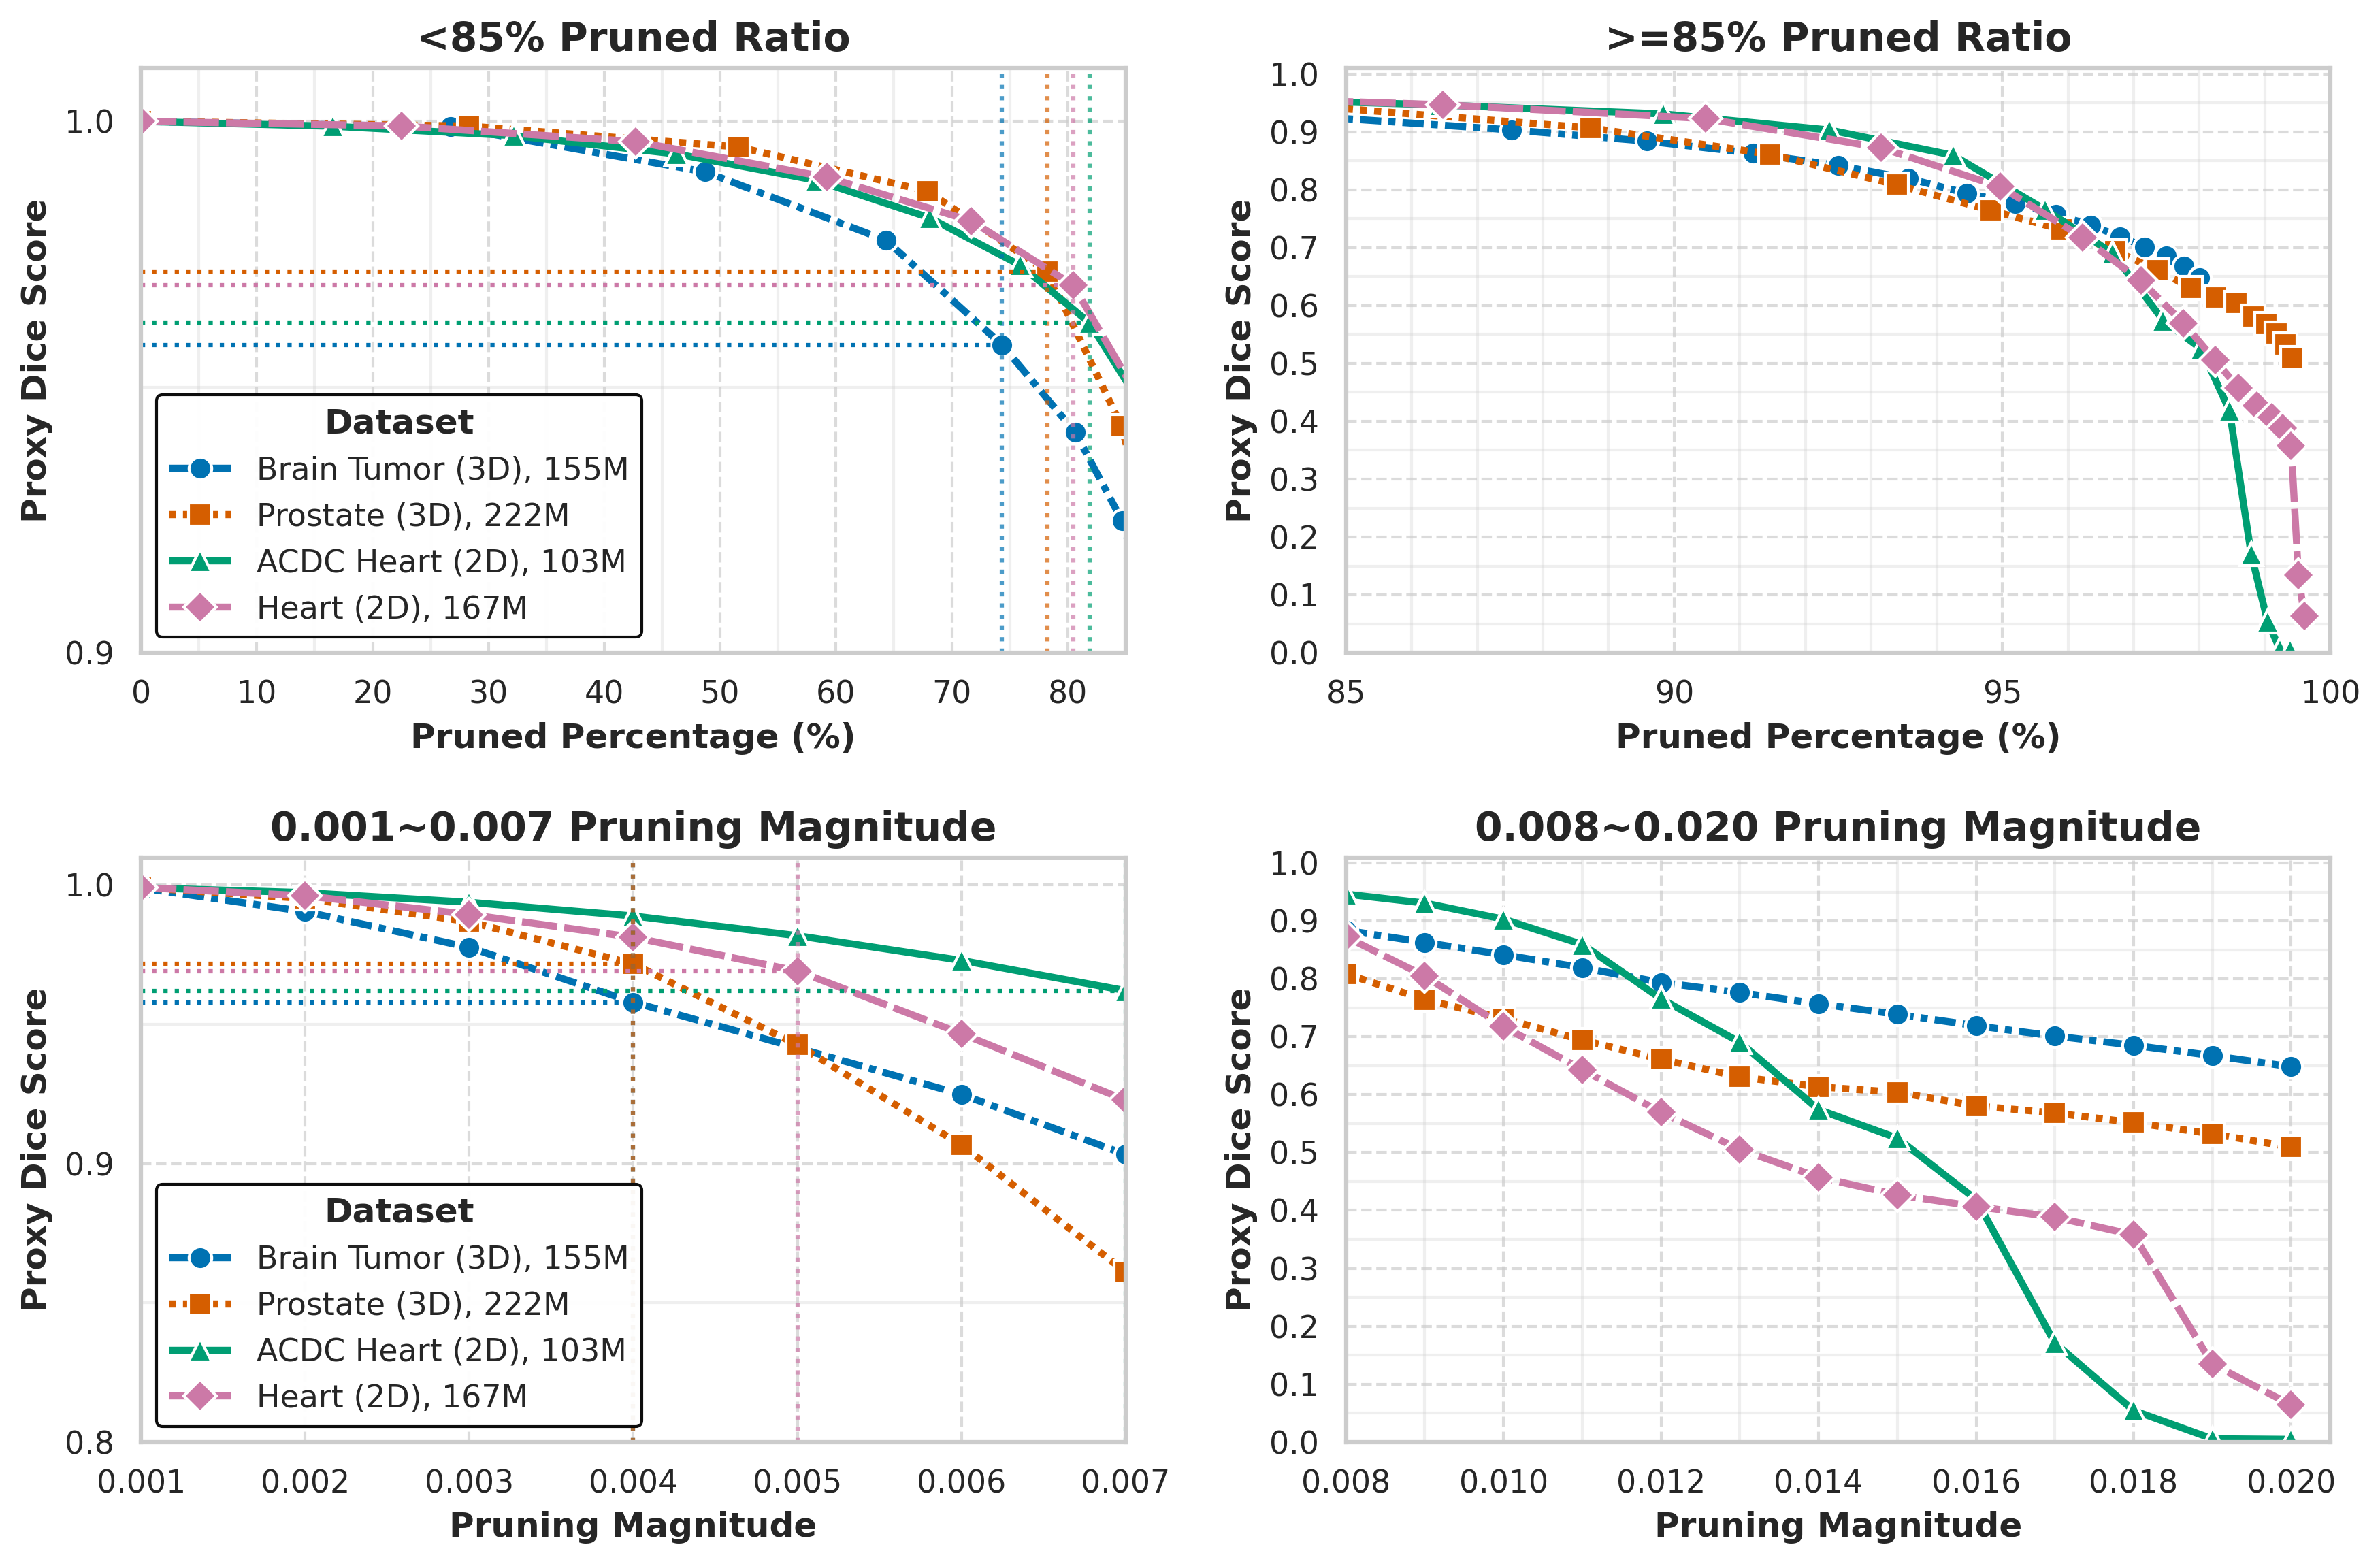


Critical pruning thresholds:
Brain Tumor (3D), 155M: 74.3%
Prostate (3D), 222M: 78.3%
ACDC Heart (2D), 103M: 81.9%
Heart (2D), 167M : 80.5%


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.patches as mpatches

# Set the aesthetic style for publication-quality figures
sns.set_theme(style="whitegrid")
# rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18
rcParams['axes.linewidth'] = 1.5
# rcParams['axes.edgecolor'] = 'black'
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5

# File paths for the CSV files (one per dataset)
data_file_paths = {
    "brain": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset001_BrainTumour/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/pruning_analysis_results.csv",
    "prostate": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset005_Prostate/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/pruning_analysis_results.csv",
    "acdc": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset027_ACDC/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv",
    "heart": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset002_Heart/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv"
}

# Human-readable labels for the legend (do not change these)
task_labels = {
    "brain": "Brain Tumor (3D), 155M",
    "prostate": "Prostate (3D), 222M",
    "acdc": "ACDC Heart (2D), 103M",
    "heart": "Heart (2D), 167M "
}

# Color scheme (colorblind-friendly) for each dataset
dataset_colors = {
    "brain": "#0072B2",     # Blue
    "prostate": "#D55E00",    # Orange-red
    "acdc": "#009E73",       # Green
    "heart": "#CC79A7"       # Pink
}

# Line styles for each dataset (making them distinct)
dataset_line_styles = {
    "brain": (0, (3, 1, 1, 1)),  # Dash-dot-dot
    "prostate": (0, (1, 1)),      # Densely dashed
    "acdc": (0, (1, 0)),          # Solid
    "heart": (0, (5, 1))          # Long dash
}

# Marker styles for each dataset
dataset_markers = {
    "brain": "o",
    "prostate": "s",
    "acdc": "^",
    "heart": "D"
}

# Read CSV files into a dictionary of DataFrames and update column names for clarity.
# We also create a new column called 'pruning_pct' that holds the pruning percentages.
datasets = {}
for dataset, file_path in data_file_paths.items():
    df_data = pd.read_csv(file_path)
    # Ensure that scientific notation strings such as "0e+" are properly interpreted
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    df_data['max_val'] = pd.to_numeric(df_data['max_val'], errors='coerce')
    # Rename 'total_percentage' to 'pruning_pct' for clarity
    df_data['pruning_pct'] = df_data['total_percentage']
    # Optionally, rename the dice performance column for clarity if you wish
    df_data.rename(columns={"performance_Dice": "dice_score"}, inplace=True)
    datasets[dataset] = df_data
    print(f"{dataset} dataframe shape: {datasets[dataset].shape}")

# Create a figure with a 2x2 grid layout:
# - Top row: Dice coefficient vs. pruning percentage
# - Bottom row: Dice coefficient vs. pruning magnitude ('max_val')
# <-- Updated figure height here (changed height from 10 to 8) -->
fig = plt.figure(figsize=(12, 8), dpi=300)
grid_spec = fig.add_gridspec(2, 2)

# Top row axes for performance vs. pruning percentage
ax_dice_pct_low = fig.add_subplot(grid_spec[0, 0])   # For pruning percentages <85%
ax_dice_pct_high = fig.add_subplot(grid_spec[0, 1])  # For pruning percentages >=85%

# Bottom row axes for performance vs. pruning magnitude
ax_dice_mag_low = fig.add_subplot(grid_spec[1, 0])   # For pruning magnitudes between 0.001 and 0.008
ax_dice_mag_high = fig.add_subplot(grid_spec[1, 1])  # For pruning magnitudes above 0.008

# Function to plot Dice coefficient vs. pruning percentage
def plot_dice_vs_pruning_pct(ax, xlim=None, ylim=None, major_locator=None, minor_locator=None):
    for dataset, df_data in datasets.items():
        # Filter rows to only include valid 'max_val' values
        df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
        filtered_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)]
        filtered_df = filtered_df.sort_values(by='pruning_pct', ascending=True)
        ax.plot(filtered_df['pruning_pct'], filtered_df['dice_score'],
                label=task_labels[dataset],
                color=dataset_colors[dataset],
                marker=dataset_markers[dataset],
                linestyle=dataset_line_styles[dataset],
                markersize=8,
                linewidth=2.5,
                markeredgecolor='white',
                markeredgewidth=1)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(True, linestyle='--', alpha=0.7)
    if major_locator is not None:
        ax.xaxis.set_major_locator(major_locator)
    if minor_locator is not None:
        ax.xaxis.set_minor_locator(minor_locator)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which='minor', alpha=0.3)

# Function to plot Dice coefficient vs. pruning magnitude ('max_val')
def plot_dice_vs_pruning_magnitude(ax, filter_func, xlim=None, ylim=None, major_locator=None, minor_locator=None):
    for dataset, df_data in datasets.items():
        # Filter rows to only include valid 'max_val' values
        df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
        filtered_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)]
        filtered_df = filtered_df.sort_values(by='pruning_pct', ascending=True)
        # Apply additional filtering based on pruning magnitude
        selected_df = filter_func(filtered_df)
        ax.plot(selected_df['max_val'], selected_df['dice_score'],
                label=task_labels[dataset],
                color=dataset_colors[dataset],
                marker=dataset_markers[dataset],
                linestyle=dataset_line_styles[dataset],
                markersize=8,
                linewidth=2.5,
                markeredgecolor='white',
                markeredgewidth=1)
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(True, linestyle='--', alpha=0.7)
    if major_locator is not None:
        ax.xaxis.set_major_locator(major_locator)
    if minor_locator is not None:
        ax.xaxis.set_minor_locator(minor_locator)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which='minor', alpha=0.3)

# ---- Top Row: Dice Coefficient vs. Pruning Percentage ----

# Left subplot: For pruning percentages less than 85%
plot_dice_vs_pruning_pct(
    ax_dice_pct_low,
    xlim=(0, 85),
    ylim=(0.9, 1.01),
    major_locator=MultipleLocator(10),
    minor_locator=MultipleLocator(5)
)
ax_dice_pct_low.set_xlabel('Pruned Percentage (%)', fontweight='bold')
ax_dice_pct_low.set_ylabel('Proxy Dice Score', fontweight='bold')
ax_dice_pct_low.set_title('<85% Pruned Ratio', fontsize=14, fontweight='bold')
legend_low = ax_dice_pct_low.legend(title='Dataset', loc='lower left', frameon=True, framealpha=0.95, edgecolor='black')
legend_low.get_title().set_fontweight('bold')

# Right subplot: For pruning percentages greater than or equal to 85%
plot_dice_vs_pruning_pct(
    ax_dice_pct_high,
    xlim=(85, 100),
    ylim=(0, 1.01),
    major_locator=MultipleLocator(5),
    minor_locator=MultipleLocator(1)
)
ax_dice_pct_high.set_xlabel('Pruned Percentage (%)', fontweight='bold')
ax_dice_pct_high.set_ylabel('Proxy Dice Score', fontweight='bold')
ax_dice_pct_high.set_title('>=85% Pruned Ratio', fontsize=14, fontweight='bold')

# ---- Add Threshold Identification for the Top Row ----
# Compute a threshold per dataset where the dice score drops below 95% of the initial score,
# then draw vertical and horizontal reference lines.
critical_pruning_pct_thresholds = {}
for dataset, df_data in datasets.items():
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    sorted_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)].sort_values(by='pruning_pct', ascending=True)
    threshold_idx = None
    for i in range(1, len(sorted_df)):
        if sorted_df.iloc[i]['dice_score'] < 0.95 * sorted_df.iloc[0]['dice_score']:
            threshold_idx = i - 1
            break
    if threshold_idx is not None and threshold_idx > 0:
        pct_threshold = sorted_df.iloc[threshold_idx]['pruning_pct']
        dice_at_threshold = sorted_df.iloc[threshold_idx]['dice_score']
        critical_pruning_pct_thresholds[dataset] = pct_threshold
        # Choose which subplot to annotate based on the pruning percentage threshold
        if pct_threshold < 85:
            ax_dice_pct_low.axvline(x=pct_threshold, color=dataset_colors[dataset], linestyle=':', alpha=0.7)
            left_edge = ax_dice_pct_low.get_xlim()[0]
            ax_dice_pct_low.hlines(dice_at_threshold, xmin=left_edge, xmax=pct_threshold, colors=dataset_colors[dataset], linestyles=':')
        else:
            ax_dice_pct_high.axvline(x=pct_threshold, color=dataset_colors[dataset], linestyle=':', alpha=0.7)
            left_edge = ax_dice_pct_high.get_xlim()[0]
            ax_dice_pct_high.hlines(dice_at_threshold, xmin=left_edge, xmax=pct_threshold, colors=dataset_colors[dataset], linestyles=':')

# ---- Bottom Row: Dice Coefficient vs. Pruning Magnitude ('max_val') ----

# Left subplot: For pruning magnitudes between 0.001 and 0.008
plot_dice_vs_pruning_magnitude(
    ax_dice_mag_low,
    filter_func=lambda df: df[(df['max_val'] >= 0.001) & (df['max_val'] <= 0.007)],
    xlim=(0.001, 0.007),
    ylim=(0.8, 1.01),
    major_locator=MultipleLocator(0.001),
    minor_locator=MultipleLocator(0.001)
)
ax_dice_mag_low.set_xlabel('Pruning Magnitude', fontweight='bold')
ax_dice_mag_low.set_ylabel('Proxy Dice Score', fontweight='bold')
ax_dice_mag_low.set_title('0.001~0.007 Pruning Magnitude', fontsize=14, fontweight='bold')
legend_mag_low = ax_dice_mag_low.legend(title='Dataset', loc='lower left', frameon=True, framealpha=0.95, edgecolor='black')
legend_mag_low.get_title().set_fontweight('bold')

# Right subplot: For pruning magnitudes above 0.008
plot_dice_vs_pruning_magnitude(
    ax_dice_mag_high,
    filter_func=lambda df: df[df['max_val'] > 0.007],
    xlim=(0.008, 0.0205),
    ylim=(0, 1.01),
    major_locator=MultipleLocator(0.002),
    minor_locator=MultipleLocator(0.001)
)
ax_dice_mag_high.set_xlabel('Pruning Magnitude', fontweight='bold')
ax_dice_mag_high.set_ylabel('Proxy Dice Score', fontweight='bold')
ax_dice_mag_high.set_title('0.008~0.020 Pruning Magnitude', fontsize=14, fontweight='bold')

# ---- Add Threshold Identification for the Bottom Row ----
# Compute a threshold for each dataset based on when the dice score drops below 95% of the initial score,
# and add corresponding reference lines to the plots.
critical_pruning_mag_thresholds = {}
for dataset, df_data in datasets.items():
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    sorted_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)].sort_values(by='pruning_pct', ascending=True)
    threshold_idx = None
    for i in range(1, len(sorted_df)):
        if sorted_df.iloc[i]['dice_score'] < 0.95 * sorted_df.iloc[0]['dice_score']:
            threshold_idx = i - 1
            break
    if threshold_idx is not None and threshold_idx > 0:
        mag_threshold = sorted_df.iloc[threshold_idx]['max_val']
        dice_at_threshold = sorted_df.iloc[threshold_idx]['dice_score']
        critical_pruning_mag_thresholds[dataset] = mag_threshold
        if 0.001 <= mag_threshold <= 0.007:
            ax_dice_mag_low.axvline(x=mag_threshold, color=dataset_colors[dataset], linestyle=':', alpha=0.7)
            left_edge = ax_dice_mag_low.get_xlim()[0]
            ax_dice_mag_low.hlines(dice_at_threshold, xmin=left_edge, xmax=mag_threshold, colors=dataset_colors[dataset], linestyles=':')
        elif mag_threshold > 0.007:
            ax_dice_mag_high.axvline(x=mag_threshold, color=dataset_colors[dataset], linestyle=':', alpha=0.7)
            left_edge = ax_dice_mag_high.get_xlim()[0]
            ax_dice_mag_high.hlines(dice_at_threshold, xmin=left_edge, xmax=mag_threshold, colors=dataset_colors[dataset], linestyles=':')

# Adjust layout and save the figure to files
plt.tight_layout()
plt.savefig('improved_pruning_performance_modified.pdf', bbox_inches='tight')
plt.savefig('improved_pruning_performance_modified.png', bbox_inches='tight', dpi=300)
plt.show()

# Print the critical pruning thresholds (for the pruning percentage plot)
print("\nCritical pruning thresholds:")
for dataset, pct_threshold in critical_pruning_pct_thresholds.items():
    print(f"{task_labels[dataset]}: {pct_threshold:.1f}%")


In [2]:
# ------------------------- Saving Individual Subplots -------------------------
# For each individual plot we:
#   1. Create a new figure and axis.
#   2. Re-plot the corresponding data (including threshold lines).
#   3. Remove the title, xlabel, and ylabel.
#   4. Save and then close that figure.

# 1. Dice vs Pruning Percentage (<85%)
fig1, ax1 = plt.subplots(figsize=(12, 8), dpi=300)
plot_dice_vs_pruning_pct(ax1,
                         xlim=(0, 85),
                         ylim=(0.9, 1.01),
                         major_locator=MultipleLocator(10),
                         minor_locator=MultipleLocator(5))
# Add threshold annotations for datasets with threshold < 85%
for dataset, df_data in datasets.items():
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    sorted_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)].sort_values(by='pruning_pct', ascending=True)
    threshold_idx = None
    for i in range(1, len(sorted_df)):
        if sorted_df.iloc[i]['dice_score'] < 0.95 * sorted_df.iloc[0]['dice_score']:
            threshold_idx = i - 1
            break
    if threshold_idx is not None and threshold_idx > 0:
        pct_threshold = sorted_df.iloc[threshold_idx]['pruning_pct']
        dice_at_threshold = sorted_df.iloc[threshold_idx]['dice_score']
        if pct_threshold < 85:
            ax1.axvline(x=pct_threshold, color=dataset_colors[dataset], linestyle=':', alpha=0.7)
            left_edge = ax1.get_xlim()[0]
            ax1.hlines(dice_at_threshold, xmin=left_edge, xmax=pct_threshold,
                       colors=dataset_colors[dataset], linestyles=':')
# Remove axis labels and title
ax1.set_title("")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()
plt.savefig('plot_dice_vs_pruning_pct_low.png', bbox_inches='tight')
plt.close(fig1)

# 2. Dice vs Pruning Percentage (>=85%)
fig2, ax2 = plt.subplots(figsize=(12, 8), dpi=300)
plot_dice_vs_pruning_pct(ax2,
                         xlim=(85, 100),
                         ylim=(0, 1.01),
                         major_locator=MultipleLocator(5),
                         minor_locator=MultipleLocator(1))
# Add threshold annotations for datasets with threshold >= 85%
for dataset, df_data in datasets.items():
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    sorted_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)].sort_values(by='pruning_pct', ascending=True)
    threshold_idx = None
    for i in range(1, len(sorted_df)):
        if sorted_df.iloc[i]['dice_score'] < 0.95 * sorted_df.iloc[0]['dice_score']:
            threshold_idx = i - 1
            break
    if threshold_idx is not None and threshold_idx > 0:
        pct_threshold = sorted_df.iloc[threshold_idx]['pruning_pct']
        dice_at_threshold = sorted_df.iloc[threshold_idx]['dice_score']
        if pct_threshold >= 85:
            ax2.axvline(x=pct_threshold, color=dataset_colors[dataset], linestyle=':', alpha=0.7)
            left_edge = ax2.get_xlim()[0]
            ax2.hlines(dice_at_threshold, xmin=left_edge, xmax=pct_threshold,
                       colors=dataset_colors[dataset], linestyles=':')
ax2.set_title("")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.savefig('plot_dice_vs_pruning_pct_high.png', bbox_inches='tight')
plt.close(fig2)

# 3. Dice vs Pruning Magnitude (low: 0.001 to 0.007)
fig3, ax3 = plt.subplots(figsize=(12, 8), dpi=300)
plot_dice_vs_pruning_magnitude(ax3,
    filter_func=lambda df: df[(df['max_val'] >= 0.001) & (df['max_val'] <= 0.007)],
    xlim=(0.001, 0.007),
    ylim=(0.8, 1.01),
    major_locator=MultipleLocator(0.001),
    minor_locator=MultipleLocator(0.001))
# Add threshold annotations for low pruning magnitude
for dataset, df_data in datasets.items():
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    sorted_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)].sort_values(by='pruning_pct', ascending=True)
    threshold_idx = None
    for i in range(1, len(sorted_df)):
        if sorted_df.iloc[i]['dice_score'] < 0.95 * sorted_df.iloc[0]['dice_score']:
            threshold_idx = i - 1
            break
    if threshold_idx is not None and threshold_idx > 0:
        mag_threshold = sorted_df.iloc[threshold_idx]['max_val']
        dice_at_threshold = sorted_df.iloc[threshold_idx]['dice_score']
        if 0.001 <= mag_threshold <= 0.007:
            ax3.axvline(x=mag_threshold, color=dataset_colors[dataset], linestyle=':', alpha=0.7)
            left_edge = ax3.get_xlim()[0]
            ax3.hlines(dice_at_threshold, xmin=left_edge, xmax=mag_threshold,
                       colors=dataset_colors[dataset], linestyles=':')
ax3.set_title("")
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.set_xticks([])
ax3.set_yticks([])
plt.tight_layout()
plt.savefig('plot_dice_vs_pruning_magnitude_low.png', bbox_inches='tight')
plt.close(fig3)

# 4. Dice vs Pruning Magnitude (high: >0.007)
fig4, ax4 = plt.subplots(figsize=(12, 8), dpi=300)
plot_dice_vs_pruning_magnitude(ax4,
    filter_func=lambda df: df[df['max_val'] > 0.007],
    xlim=(0.008, 0.0205),
    ylim=(0, 1.01),
    major_locator=MultipleLocator(0.002),
    minor_locator=MultipleLocator(0.001))
# Add threshold annotations for high pruning magnitude
for dataset, df_data in datasets.items():
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    sorted_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)].sort_values(by='pruning_pct', ascending=True)
    threshold_idx = None
    for i in range(1, len(sorted_df)):
        if sorted_df.iloc[i]['dice_score'] < 0.95 * sorted_df.iloc[0]['dice_score']:
            threshold_idx = i - 1
            break
    if threshold_idx is not None and threshold_idx > 0:
        mag_threshold = sorted_df.iloc[threshold_idx]['max_val']
        dice_at_threshold = sorted_df.iloc[threshold_idx]['dice_score']
        if mag_threshold > 0.007:
            ax4.axvline(x=mag_threshold, color=dataset_colors[dataset], linestyle=':', alpha=0.7)
            left_edge = ax4.get_xlim()[0]
            ax4.hlines(dice_at_threshold, xmin=left_edge, xmax=mag_threshold,
                       colors=dataset_colors[dataset], linestyles=':')
ax4.set_title("")
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.set_xticks([])
ax4.set_yticks([])
plt.tight_layout()
plt.savefig('plot_dice_vs_pruning_magnitude_high.png', bbox_inches='tight')
plt.close(fig4)

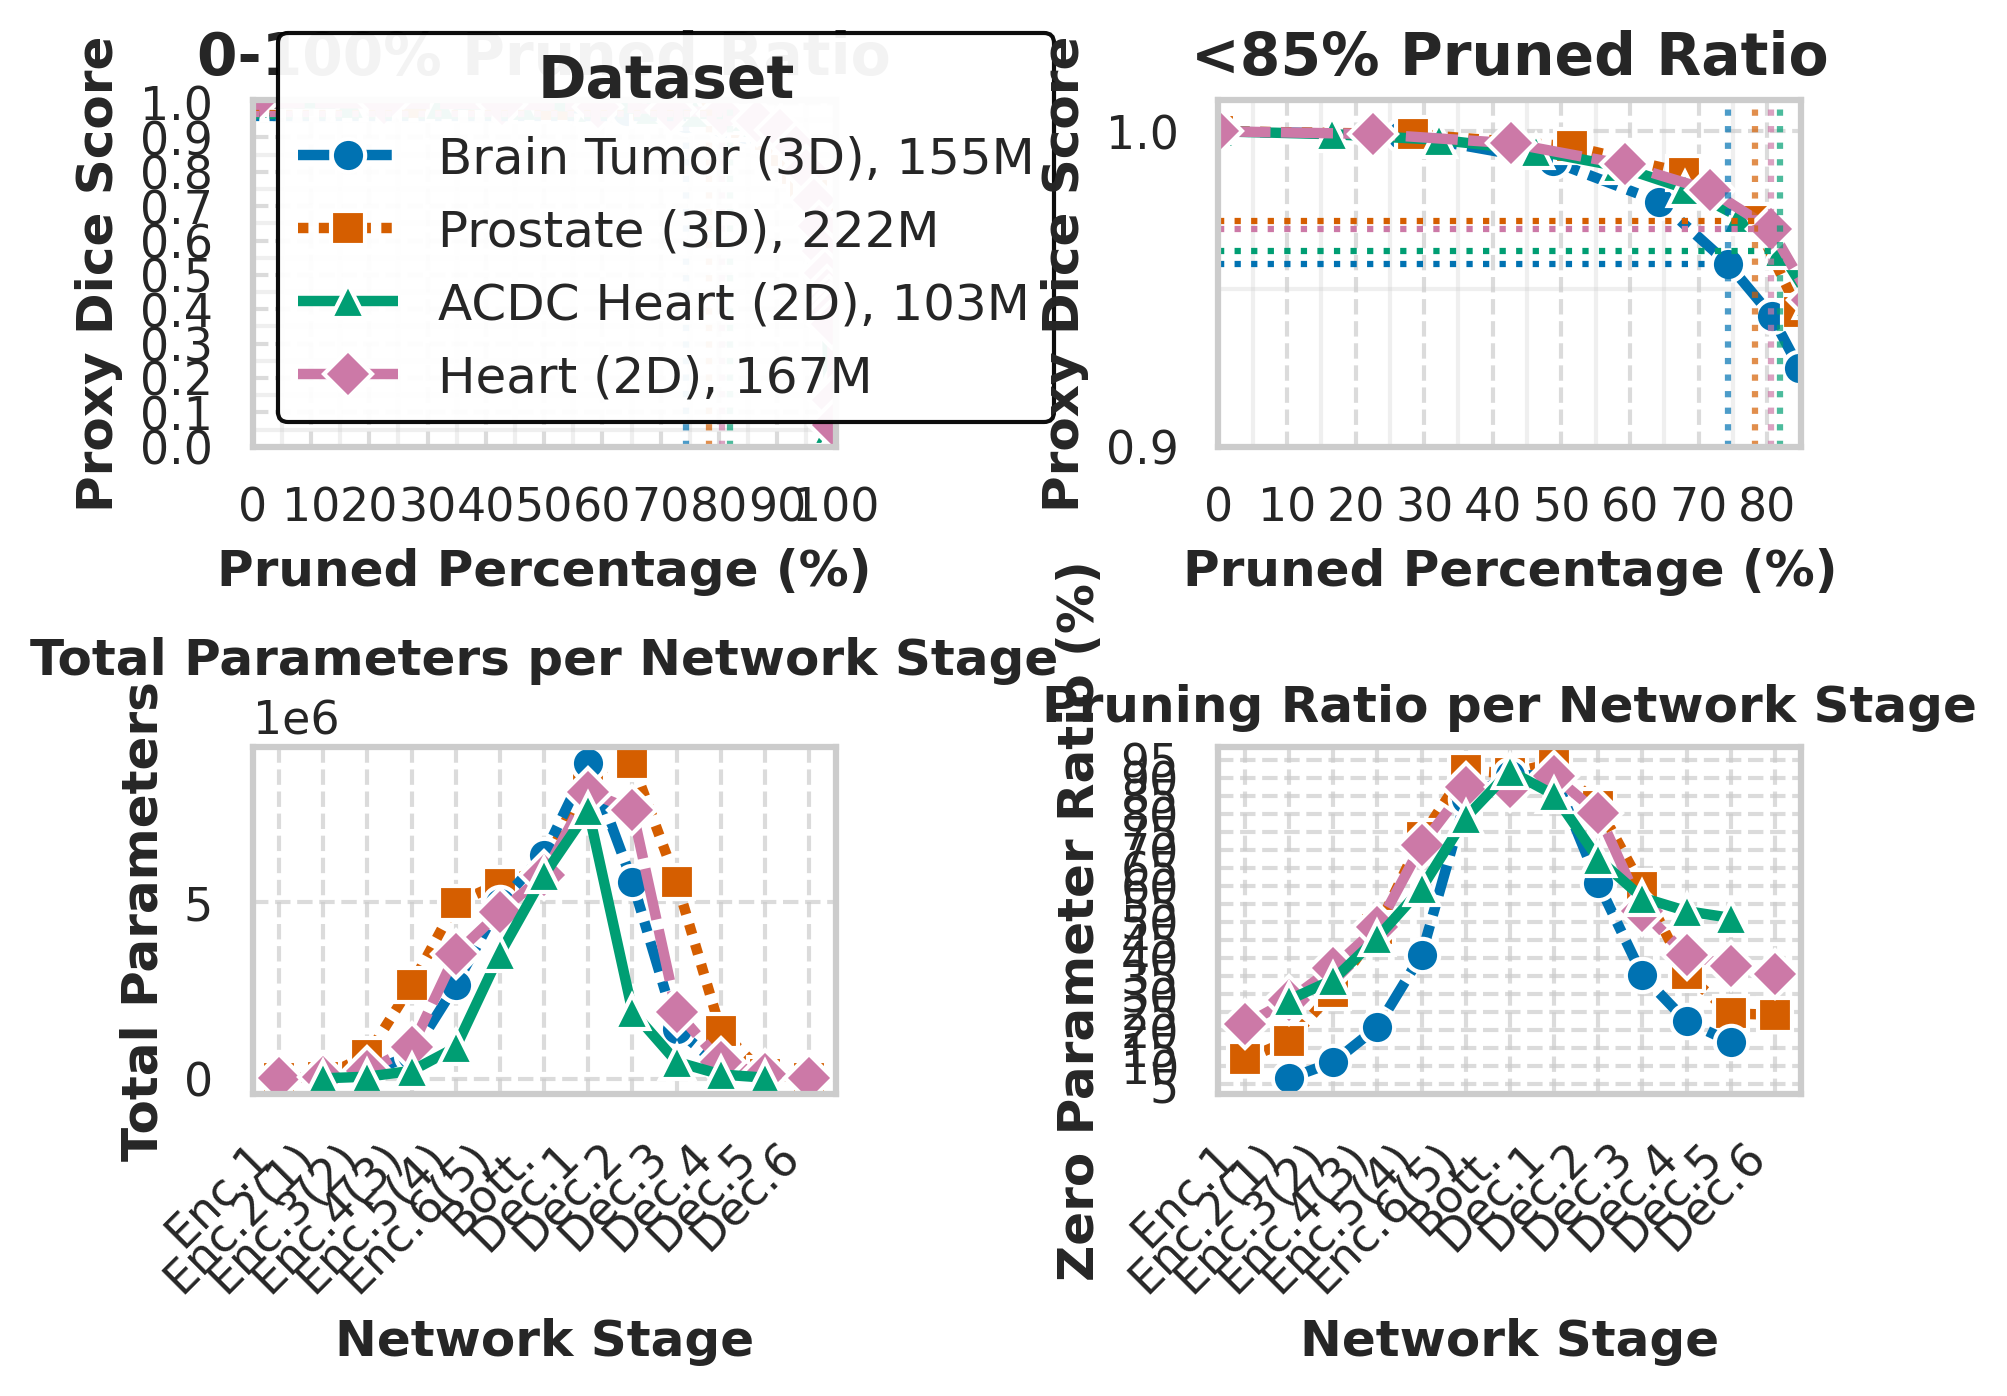


Critical pruning thresholds (Top Row):
Brain Tumor (3D), 155M: 74.3%
Prostate (3D), 222M: 78.3%
ACDC Heart (2D), 103M: 81.9%
Heart (2D), 167M: 80.5%


In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.patches as mpatches

# ============================================================================
# 1. Set publication-quality aesthetics (for both parts)
# ============================================================================
sns.set_theme(style="whitegrid")
rcParams['font.size'] = 9
rcParams['svg.fonttype'] = 'none'
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5

# ============================================================================
# 2. Define file paths and dataset aesthetics
# ----------------------------------------------------------------------------
# (Update the file paths below with your actual paths)

# File paths for top row CSV files (Dice vs. pruning percentage)
data_file_paths = {
    "brain": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset001_BrainTumour/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/pruning_analysis_results.csv",
    "prostate": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset005_Prostate/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/pruning_analysis_results.csv",
    "acdc": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset027_ACDC/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv",
    "heart": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset002_Heart/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv"
}

# File paths for bottom row text files (stage analysis)
paths = {
    "prostate": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset005_Prostate/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/max_val_4e-3__min_val_-4e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "brain":    "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset001_BrainTumour/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/max_val_4e-3__min_val_-4e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "heart":    "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset002_Heart/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/max_val_5e-3__min_val_-5e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "acdc":     "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset027_ACDC/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/max_val_7e-3__min_val_-7e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt"
}

# Human-readable labels for both parts
task_labels = {
    "brain": "Brain Tumor (3D), 155M",
    "prostate": "Prostate (3D), 222M",
    "acdc": "ACDC Heart (2D), 103M",
    "heart": "Heart (2D), 167M"
}

# Dataset aesthetics (colorblind-friendly colors, line styles, markers)
dataset_colors = {
    "brain": "#0072B2",
    "prostate": "#D55E00",
    "acdc": "#009E73",
    "heart": "#CC79A7"
}

dataset_line_styles = {
    "brain": (0, (3, 1, 1, 1)),
    "prostate": (0, (1, 1)),
    "acdc": (0, (1, 0)),
    "heart": (0, (5, 1))
}

dataset_markers = {
    "brain": "o",
    "prostate": "s",
    "acdc": "^",
    "heart": "D"
}

# ============================================================================
# 3. Top Row: Load CSV Data and Plot Dice vs. Pruned Percentage
# ----------------------------------------------------------------------------
datasets = {}
for dataset, file_path in data_file_paths.items():
    df_data = pd.read_csv(file_path)
    # Ensure that scientific notation strings (e.g., "0e+") are properly interpreted
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    df_data['max_val'] = pd.to_numeric(df_data['max_val'], errors='coerce')
    df_data['pruning_pct'] = df_data['total_percentage']
    df_data.rename(columns={"performance_Dice": "dice_score"}, inplace=True)
    datasets[dataset] = df_data

# Create a composite figure with a 2x2 grid layout.
cm = 0.393701
fig = plt.figure(figsize=(15.3*cm, 12*cm), dpi=300)
grid_spec = fig.add_gridspec(2, 2)

# Top row axes:
#   - Left: Full range 0–100%
#   - Right: Only data with <85% pruned ratio
ax_dice_pct_full = fig.add_subplot(grid_spec[0, 0])
ax_dice_pct_low = fig.add_subplot(grid_spec[0, 1])

def plot_dice_vs_pruning_pct(ax, xlim, ylim, major_locator, minor_locator):
    for dataset, df_data in datasets.items():
        df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
        filtered_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)]
        filtered_df = filtered_df.sort_values(by='pruning_pct', ascending=True)
        ax.plot(filtered_df['pruning_pct'], filtered_df['dice_score'],
                label=task_labels[dataset],
                color=dataset_colors[dataset],
                marker=dataset_markers[dataset],
                linestyle=dataset_line_styles[dataset],
                markersize=8, linewidth=2.5,
                markeredgecolor='white', markeredgewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which='minor', alpha=0.3)

# Plot for the full range (0–100%)
plot_dice_vs_pruning_pct(ax_dice_pct_full, (0, 100), (0, 1.01), MultipleLocator(10), MultipleLocator(5))
ax_dice_pct_full.set_xlabel('Pruned Percentage (%)', fontweight='bold')
ax_dice_pct_full.set_ylabel('Proxy Dice Score', fontweight='bold')
ax_dice_pct_full.set_title('0-100% Pruned Ratio', fontsize=14, fontweight='bold')
legend_full = ax_dice_pct_full.legend(title='Dataset', loc='lower left',
                                      frameon=True, framealpha=0.95, edgecolor='black', fontsize=12, title_fontsize=14)
legend_full.get_title().set_fontweight('bold')

# Plot for <85% pruned percentage
plot_dice_vs_pruning_pct(ax_dice_pct_low, (0, 85), (0.9, 1.01), MultipleLocator(10), MultipleLocator(5))
ax_dice_pct_low.set_xlabel('Pruned Percentage (%)', fontweight='bold')
ax_dice_pct_low.set_ylabel('Proxy Dice Score', fontweight='bold')
ax_dice_pct_low.set_title('<85% Pruned Ratio', fontsize=14, fontweight='bold')
# legend_low = ax_dice_pct_low.legend(title='Dataset', loc='lower left',
#                                     frameon=True, framealpha=0.95, edgecolor='black')
# legend_low.get_title().set_fontweight('bold')

# Optional: add threshold annotations as in your previous code...
critical_pruning_pct_thresholds = {}
for dataset, df_data in datasets.items():
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    sorted_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)] \
                    .sort_values(by='pruning_pct', ascending=True)
    threshold_idx = None
    for i in range(1, len(sorted_df)):
        if sorted_df.iloc[i]['dice_score'] < 0.95 * sorted_df.iloc[0]['dice_score']:
            threshold_idx = i - 1
            break
    if threshold_idx is not None and threshold_idx > 0:
        pct_threshold = sorted_df.iloc[threshold_idx]['pruning_pct']
        dice_at_threshold = sorted_df.iloc[threshold_idx]['dice_score']
        critical_pruning_pct_thresholds[dataset] = pct_threshold
        left_edge_full = ax_dice_pct_full.get_xlim()[0]
        ax_dice_pct_full.axvline(x=pct_threshold, color=dataset_colors[dataset],
                                 linestyle=':', alpha=0.7)
        ax_dice_pct_full.hlines(dice_at_threshold, xmin=left_edge_full, xmax=pct_threshold,
                                colors=dataset_colors[dataset], linestyles=':')
        if pct_threshold < 85:
            left_edge_low = ax_dice_pct_low.get_xlim()[0]
            ax_dice_pct_low.axvline(x=pct_threshold, color=dataset_colors[dataset],
                                    linestyle=':', alpha=0.7)
            ax_dice_pct_low.hlines(dice_at_threshold, xmin=left_edge_low, xmax=pct_threshold,
                                   colors=dataset_colors[dataset], linestyles=':')

# ============================================================================
# 4. Bottom Row: Stage Analysis Plots (Total Parameters & Zero Parameter Ratio)
# ----------------------------------------------------------------------------
# --- Parsing function based on your provided code ---
def analyze_zero_parameter_file(file_path):
    """
    Parses the zero_parameter_analysis_0.txt file to extract zeros and total parameters.

    For the encoder, only lines starting with "encoder.stages" are used.
    For the decoder:
      - Lines starting with "decoder.stages" use the stage number as-is.
      - Lines starting with "decoder.transpconvs" or "decoder.seg_layers":
           * If stage index is 0: merge into the encoder bottleneck.
           * Otherwise, subtract 1 from the stage index.

    Returns:
        encoder_stages (dict): {stage_index: {"zeros": int, "total": int}}
        decoder_stages (dict): {adjusted_stage_index: {"zeros": int, "total": int}}
    """
    encoder_stages = {}
    decoder_stages = {}
    decoder_to_merge = {"zeros": 0, "total": 0}
    prefix_pattern = re.compile(r'^(encoder|decoder)\.(?P<subtype>stages|transpconvs|seg_layers)\.(?P<stage>\d+)')
    num_pattern = re.compile(r':\s*(\d+)/(\d+)\s+zeros')
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("SUMMARY:"):
                continue
            prefix_match = prefix_pattern.match(line)
            if not prefix_match:
                continue
            arch = prefix_match.group(1)
            subtype = prefix_match.group("subtype")
            stage_idx = int(prefix_match.group("stage"))
            if arch == "encoder":
                if subtype != "stages":
                    continue
                if stage_idx not in encoder_stages:
                    encoder_stages[stage_idx] = {"zeros": 0, "total": 0}
                num_match = num_pattern.search(line)
                if not num_match:
                    continue
                zeros = int(num_match.group(1))
                total = int(num_match.group(2))
                encoder_stages[stage_idx]["zeros"] += zeros
                encoder_stages[stage_idx]["total"] += total
            else:  # decoder
                num_match = num_pattern.search(line)
                if not num_match:
                    continue
                zeros = int(num_match.group(1))
                total = int(num_match.group(2))
                if subtype == "stages":
                    new_stage = stage_idx
                    if new_stage not in decoder_stages:
                        decoder_stages[new_stage] = {"zeros": 0, "total": 0}
                    decoder_stages[new_stage]["zeros"] += zeros
                    decoder_stages[new_stage]["total"] += total
                elif subtype in ("transpconvs", "seg_layers"):
                    new_stage = stage_idx - 1
                    if new_stage < 0:
                        # Merge into encoder bottleneck
                        decoder_to_merge["zeros"] += zeros
                        decoder_to_merge["total"] += total
                    else:
                        if new_stage not in decoder_stages:
                            decoder_stages[new_stage] = {"zeros": 0, "total": 0}
                        decoder_stages[new_stage]["zeros"] += zeros
                        decoder_stages[new_stage]["total"] += total
    if decoder_to_merge["total"] > 0:
        if encoder_stages:
            bottleneck_index = max(encoder_stages.keys())
            encoder_stages[bottleneck_index]["zeros"] += decoder_to_merge["zeros"]
            encoder_stages[bottleneck_index]["total"] += decoder_to_merge["total"]
        else:
            encoder_stages[0] = decoder_to_merge
    return encoder_stages, decoder_stages

# Build a dictionary to hold stage information for each dataset.
dataset_info = {}
max_encoder_depth = 0
max_decoder_depth = 0
for dataset, file_path in paths.items():
    try:
        encoder_stages, decoder_stages = analyze_zero_parameter_file(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        continue
    e_i = max(encoder_stages.keys()) + 1 if encoder_stages else 0
    d_i = max(decoder_stages.keys()) + 1 if decoder_stages else 0
    max_encoder_depth = max(max_encoder_depth, e_i)
    max_decoder_depth = max(max_decoder_depth, d_i)
    dataset_info[dataset] = {
        "encoder_dict": encoder_stages,
        "decoder_dict": decoder_stages,
        "num_encoder_stages": e_i,
        "num_decoder_stages": d_i
    }

# Align stage data across datasets.
E = max_encoder_depth
D = max_decoder_depth
x_positions = list(range(1, E + D + 1))  # x positions: 1 ... (E+D)

total_params_data = {}
zero_ratio_data = {}
for dataset, info in dataset_info.items():
    e_i = info["num_encoder_stages"]
    d_i = info["num_decoder_stages"]
    enc_dict = info["encoder_dict"]
    dec_dict = info["decoder_dict"]
    y_total = [None] * (E + D)
    y_ratio = [None] * (E + D)
    # Map encoder stages: assign x = E - e_i + (k + 1) for stage k.
    for k in range(e_i):
        x_enc = E - e_i + (k + 1)
        if 1 <= x_enc <= (E + D):
            zeros_k = enc_dict[k]["zeros"]
            total_k = enc_dict[k]["total"]
            y_total[x_enc - 1] = total_k
            y_ratio[x_enc - 1] = (zeros_k / total_k * 100) if total_k > 0 else None
    # Map decoder stages: assign x = E + (j + 1) for stage j.
    for j in range(d_i):
        x_dec = E + (j + 1)
        if 1 <= x_dec <= (E + D):
            zeros_j = dec_dict[j]["zeros"]
            total_j = dec_dict[j]["total"]
            y_total[x_dec - 1] = total_j
            y_ratio[x_dec - 1] = (zeros_j / total_j * 100) if total_j > 0 else None
    total_params_data[dataset] = y_total
    zero_ratio_data[dataset] = y_ratio

# Create custom x-axis tick labels.
x_labels = []
for x in x_positions:
    if x < E:
        if x == 1:
            x_labels.append("Enc.1")
        else:
            x_labels.append(f"Enc.{x}({x-1})")
    elif x == E:
        x_labels.append("Bott.")
    else:
        x_labels.append(f"Dec.{x - E}")

# Create bottom row axes for stage analysis.
ax_total = fig.add_subplot(grid_spec[1, 0])
ax_ratio = fig.add_subplot(grid_spec[1, 1])

# Plot Total Parameters and Zero Parameter Ratio for each dataset.
for dataset in dataset_info.keys():
    y_total = total_params_data[dataset]
    y_ratio = zero_ratio_data[dataset]
    ax_total.plot(
        x_positions,
        y_total,
        label=task_labels.get(dataset, dataset),
        color=dataset_colors[dataset],
        marker=dataset_markers[dataset],
        linestyle=dataset_line_styles[dataset],
        markersize=8, linewidth=2.5,
        markeredgecolor='white', markeredgewidth=1
    )
    ax_ratio.plot(
        x_positions,
        y_ratio,
        label=task_labels.get(dataset, dataset),
        color=dataset_colors[dataset],
        marker=dataset_markers[dataset],
        linestyle=dataset_line_styles[dataset],
        markersize=8, linewidth=2.5,
        markeredgecolor='white', markeredgewidth=1
    )

# Style the Total Parameters plot.
ax_total.set_xlabel("Network Stage", fontweight='bold')
ax_total.set_ylabel("Total Parameters", fontweight='bold')
ax_total.set_title("Total Parameters per Network Stage", fontweight='bold')
ax_total.grid(True, linestyle='--', alpha=0.7)
ax_total.xaxis.set_major_locator(MultipleLocator(1))
ax_total.set_xticks(x_positions)
ax_total.set_xticklabels(x_labels, rotation=45, ha='right')
# ax_total.legend(title="Dataset", loc="upper left", frameon=True, framealpha=0.95, edgecolor='black')

# Style the Zero Parameter Ratio plot.
ax_ratio.set_xlabel("Network Stage", fontweight='bold')
ax_ratio.set_ylabel("Zero Parameter Ratio (%)", fontweight='bold')
ax_ratio.set_title("Pruning Ratio per Network Stage", fontweight='bold')
ax_ratio.grid(True, linestyle='--', alpha=0.7)
ax_ratio.xaxis.set_major_locator(MultipleLocator(1))
ax_ratio.set_xticks(x_positions)
ax_ratio.set_xticklabels(x_labels, rotation=45, ha='right')
# ax_ratio.legend(title="Dataset", loc="upper left", frameon=True, framealpha=0.95, edgecolor='black')
ax_ratio.yaxis.set_major_locator(MultipleLocator(5))
ax_ratio.yaxis.set_minor_locator(MultipleLocator(1))

# ============================================================================
# 5. Final Layout, Save, and Show Figure
# ============================================================================
plt.tight_layout()
plt.savefig('combined_pruning_performance.pdf', bbox_inches='tight')
plt.savefig('combined_pruning_performance.svg', bbox_inches='tight')
plt.savefig('combined_pruning_performance.png', bbox_inches='tight', dpi=300)
plt.show()

# Optionally, print critical thresholds from the top row
print("\nCritical pruning thresholds (Top Row):")
for dataset, pct_threshold in critical_pruning_pct_thresholds.items():
    print(f"{task_labels[dataset]}: {pct_threshold:.1f}%")


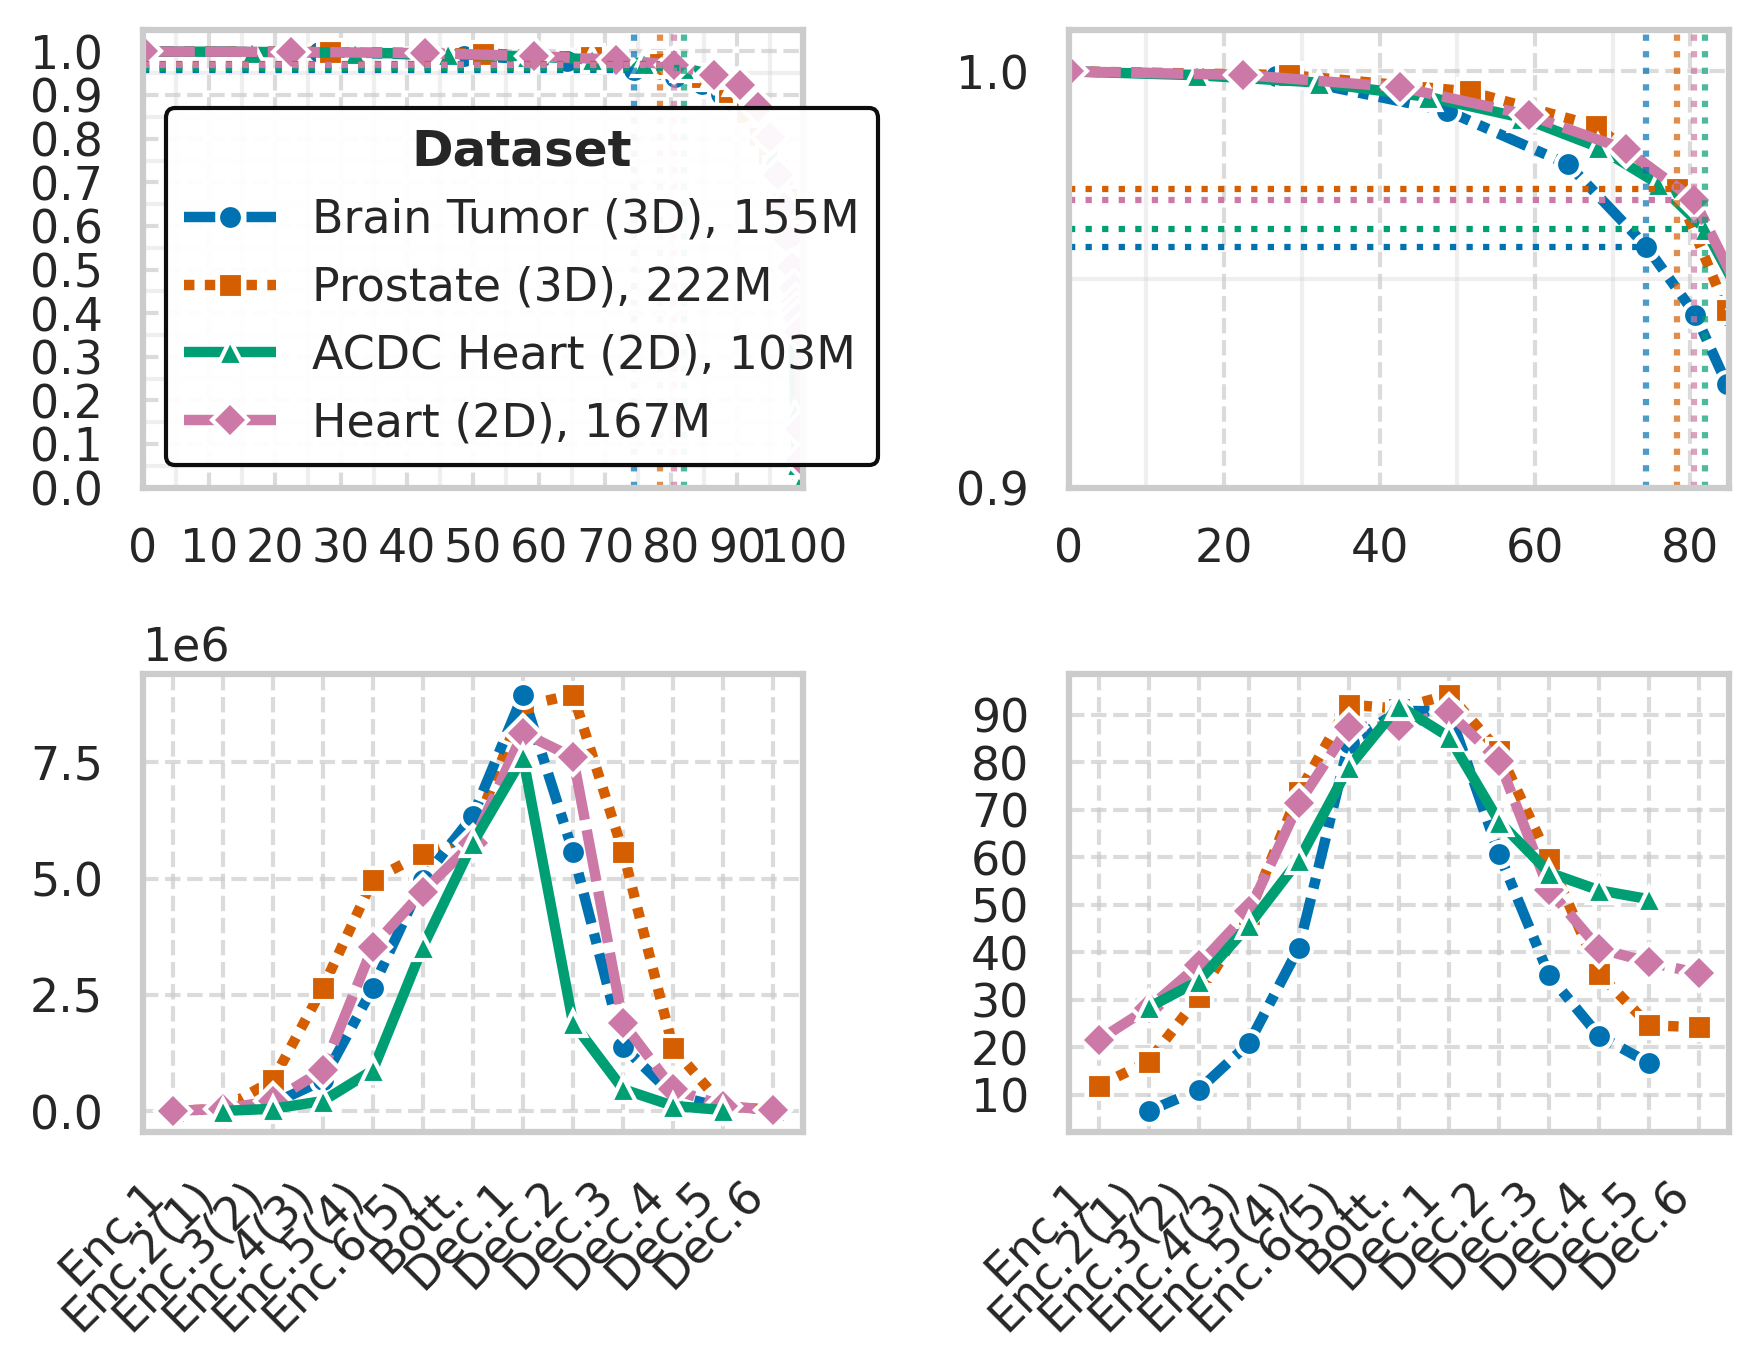


Critical pruning thresholds (Top Row):
Brain Tumor (3D), 155M: 74.3%
Prostate (3D), 222M: 78.3%
ACDC Heart (2D), 103M: 81.9%
Heart (2D), 167M: 80.5%


In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.patches as mpatches

# ============================================================================
# 1. Set publication-quality aesthetics (for both parts)
# ============================================================================
sns.set_theme(style="whitegrid")
rcParams['svg.fonttype'] = 'none'
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5

# ============================================================================
# 2. Define file paths and dataset aesthetics
# ----------------------------------------------------------------------------
# (Update the file paths below with your actual paths)

# File paths for top row CSV files (Dice vs. pruning percentage)
data_file_paths = {
    "brain": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset001_BrainTumour/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/pruning_analysis_results.csv",
    "prostate": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset005_Prostate/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/pruning_analysis_results.csv",
    "acdc": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset027_ACDC/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv",
    "heart": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset002_Heart/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv"
}

# File paths for bottom row text files (stage analysis)
paths = {
    "prostate": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset005_Prostate/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/max_val_4e-3__min_val_-4e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "brain":    "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset001_BrainTumour/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/max_val_4e-3__min_val_-4e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "heart":    "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset002_Heart/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/max_val_5e-3__min_val_-5e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "acdc":     "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset027_ACDC/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/max_val_7e-3__min_val_-7e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt"
}

# Human-readable labels for both parts
task_labels = {
    "brain": "Brain Tumor (3D), 155M",
    "prostate": "Prostate (3D), 222M",
    "acdc": "ACDC Heart (2D), 103M",
    "heart": "Heart (2D), 167M"
}

# Dataset aesthetics (colorblind-friendly colors, line styles, markers)
dataset_colors = {
    "brain": "#0072B2",
    "prostate": "#D55E00",
    "acdc": "#009E73",
    "heart": "#CC79A7"
}

dataset_line_styles = {
    "brain": (0, (3, 1, 1, 1)),
    "prostate": (0, (1, 1)),
    "acdc": (0, (1, 0)),
    "heart": (0, (5, 1))
}

dataset_markers = {
    "brain": "o",
    "prostate": "s",
    "acdc": "^",
    "heart": "D"
}

# ============================================================================
# 3. Top Row: Load CSV Data and Plot Dice vs. Pruned Percentage
# ----------------------------------------------------------------------------
datasets = {}
for dataset, file_path in data_file_paths.items():
    df_data = pd.read_csv(file_path)
    # Ensure that scientific notation strings (e.g., "0e+") are properly interpreted
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    df_data['max_val'] = pd.to_numeric(df_data['max_val'], errors='coerce')
    df_data['pruning_pct'] = df_data['total_percentage']
    df_data.rename(columns={"performance_Dice": "dice_score"}, inplace=True)
    datasets[dataset] = df_data

# Create a composite figure with a 2x2 grid layout.
cm = 0.393701
fig = plt.figure(figsize=(15.3*cm, 12*cm), dpi=300)
grid_spec = fig.add_gridspec(2, 2)

# Top row axes:
#   - Left: Full range 0–100%
#   - Right: Only data with <85% pruned ratio
ax_dice_pct_full = fig.add_subplot(grid_spec[0, 0])
ax_dice_pct_low = fig.add_subplot(grid_spec[0, 1])

def plot_dice_vs_pruning_pct(ax, xlim, ylim, major_locator, minor_locator):
    for dataset, df_data in datasets.items():
        df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
        filtered_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)]
        filtered_df = filtered_df.sort_values(by='pruning_pct', ascending=True)
        ax.plot(filtered_df['pruning_pct'], filtered_df['dice_score'],
                label=task_labels[dataset],
                color=dataset_colors[dataset],
                marker=dataset_markers[dataset],
                linestyle=dataset_line_styles[dataset],
                linewidth=2.5,
                markeredgecolor='white', markeredgewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which='minor', alpha=0.3)

# Plot for the full range (0–100%)
plot_dice_vs_pruning_pct(ax_dice_pct_full, (0, 100), (0, 1.05), MultipleLocator(10), MultipleLocator(5))
legend_full = ax_dice_pct_full.legend(title='Dataset', loc='lower left',
                                      frameon=True, framealpha=0.95, edgecolor='black')
legend_full.get_title().set_fontweight('bold')

# Plot for <85% pruned percentage
plot_dice_vs_pruning_pct(ax_dice_pct_low, (0, 85), (0.9, 1.01), MultipleLocator(20), MultipleLocator(10))
# legend_low = ax_dice_pct_low.legend(title='Dataset', loc='lower left',
#                                     frameon=True, framealpha=0.95, edgecolor='black')
# legend_low.get_title().set_fontweight('bold')

# Optional: add threshold annotations as in your previous code...
critical_pruning_pct_thresholds = {}
for dataset, df_data in datasets.items():
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    sorted_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)] \
                    .sort_values(by='pruning_pct', ascending=True)
    threshold_idx = None
    for i in range(1, len(sorted_df)):
        if sorted_df.iloc[i]['dice_score'] < 0.95 * sorted_df.iloc[0]['dice_score']:
            threshold_idx = i - 1
            break
    if threshold_idx is not None and threshold_idx > 0:
        pct_threshold = sorted_df.iloc[threshold_idx]['pruning_pct']
        dice_at_threshold = sorted_df.iloc[threshold_idx]['dice_score']
        critical_pruning_pct_thresholds[dataset] = pct_threshold
        left_edge_full = ax_dice_pct_full.get_xlim()[0]
        ax_dice_pct_full.axvline(x=pct_threshold, color=dataset_colors[dataset],
                                 linestyle=':', alpha=0.7)
        ax_dice_pct_full.hlines(dice_at_threshold, xmin=left_edge_full, xmax=pct_threshold,
                                colors=dataset_colors[dataset], linestyles=':')
        if pct_threshold < 85:
            left_edge_low = ax_dice_pct_low.get_xlim()[0]
            ax_dice_pct_low.axvline(x=pct_threshold, color=dataset_colors[dataset],
                                    linestyle=':', alpha=0.7)
            ax_dice_pct_low.hlines(dice_at_threshold, xmin=left_edge_low, xmax=pct_threshold,
                                   colors=dataset_colors[dataset], linestyles=':')

# ============================================================================
# 4. Bottom Row: Stage Analysis Plots (Total Parameters & Zero Parameter Ratio)
# ----------------------------------------------------------------------------
# --- Parsing function based on your provided code ---
def analyze_zero_parameter_file(file_path):
    """
    Parses the zero_parameter_analysis_0.txt file to extract zeros and total parameters.

    For the encoder, only lines starting with "encoder.stages" are used.
    For the decoder:
      - Lines starting with "decoder.stages" use the stage number as-is.
      - Lines starting with "decoder.transpconvs" or "decoder.seg_layers":
           * If stage index is 0: merge into the encoder bottleneck.
           * Otherwise, subtract 1 from the stage index.

    Returns:
        encoder_stages (dict): {stage_index: {"zeros": int, "total": int}}
        decoder_stages (dict): {adjusted_stage_index: {"zeros": int, "total": int}}
    """
    encoder_stages = {}
    decoder_stages = {}
    decoder_to_merge = {"zeros": 0, "total": 0}
    prefix_pattern = re.compile(r'^(encoder|decoder)\.(?P<subtype>stages|transpconvs|seg_layers)\.(?P<stage>\d+)')
    num_pattern = re.compile(r':\s*(\d+)/(\d+)\s+zeros')
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("SUMMARY:"):
                continue
            prefix_match = prefix_pattern.match(line)
            if not prefix_match:
                continue
            arch = prefix_match.group(1)
            subtype = prefix_match.group("subtype")
            stage_idx = int(prefix_match.group("stage"))
            if arch == "encoder":
                if subtype != "stages":
                    continue
                if stage_idx not in encoder_stages:
                    encoder_stages[stage_idx] = {"zeros": 0, "total": 0}
                num_match = num_pattern.search(line)
                if not num_match:
                    continue
                zeros = int(num_match.group(1))
                total = int(num_match.group(2))
                encoder_stages[stage_idx]["zeros"] += zeros
                encoder_stages[stage_idx]["total"] += total
            else:  # decoder
                num_match = num_pattern.search(line)
                if not num_match:
                    continue
                zeros = int(num_match.group(1))
                total = int(num_match.group(2))
                if subtype == "stages":
                    new_stage = stage_idx
                    if new_stage not in decoder_stages:
                        decoder_stages[new_stage] = {"zeros": 0, "total": 0}
                    decoder_stages[new_stage]["zeros"] += zeros
                    decoder_stages[new_stage]["total"] += total
                elif subtype in ("transpconvs", "seg_layers"):
                    new_stage = stage_idx - 1
                    if new_stage < 0:
                        # Merge into encoder bottleneck
                        decoder_to_merge["zeros"] += zeros
                        decoder_to_merge["total"] += total
                    else:
                        if new_stage not in decoder_stages:
                            decoder_stages[new_stage] = {"zeros": 0, "total": 0}
                        decoder_stages[new_stage]["zeros"] += zeros
                        decoder_stages[new_stage]["total"] += total
    if decoder_to_merge["total"] > 0:
        if encoder_stages:
            bottleneck_index = max(encoder_stages.keys())
            encoder_stages[bottleneck_index]["zeros"] += decoder_to_merge["zeros"]
            encoder_stages[bottleneck_index]["total"] += decoder_to_merge["total"]
        else:
            encoder_stages[0] = decoder_to_merge
    return encoder_stages, decoder_stages

# Build a dictionary to hold stage information for each dataset.
dataset_info = {}
max_encoder_depth = 0
max_decoder_depth = 0
for dataset, file_path in paths.items():
    try:
        encoder_stages, decoder_stages = analyze_zero_parameter_file(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        continue
    e_i = max(encoder_stages.keys()) + 1 if encoder_stages else 0
    d_i = max(decoder_stages.keys()) + 1 if decoder_stages else 0
    max_encoder_depth = max(max_encoder_depth, e_i)
    max_decoder_depth = max(max_decoder_depth, d_i)
    dataset_info[dataset] = {
        "encoder_dict": encoder_stages,
        "decoder_dict": decoder_stages,
        "num_encoder_stages": e_i,
        "num_decoder_stages": d_i
    }

# Align stage data across datasets.
E = max_encoder_depth
D = max_decoder_depth
x_positions = list(range(1, E + D + 1))  # x positions: 1 ... (E+D)

total_params_data = {}
zero_ratio_data = {}
for dataset, info in dataset_info.items():
    e_i = info["num_encoder_stages"]
    d_i = info["num_decoder_stages"]
    enc_dict = info["encoder_dict"]
    dec_dict = info["decoder_dict"]
    y_total = [None] * (E + D)
    y_ratio = [None] * (E + D)
    # Map encoder stages: assign x = E - e_i + (k + 1) for stage k.
    for k in range(e_i):
        x_enc = E - e_i + (k + 1)
        if 1 <= x_enc <= (E + D):
            zeros_k = enc_dict[k]["zeros"]
            total_k = enc_dict[k]["total"]
            y_total[x_enc - 1] = total_k
            y_ratio[x_enc - 1] = (zeros_k / total_k * 100) if total_k > 0 else None
    # Map decoder stages: assign x = E + (j + 1) for stage j.
    for j in range(d_i):
        x_dec = E + (j + 1)
        if 1 <= x_dec <= (E + D):
            zeros_j = dec_dict[j]["zeros"]
            total_j = dec_dict[j]["total"]
            y_total[x_dec - 1] = total_j
            y_ratio[x_dec - 1] = (zeros_j / total_j * 100) if total_j > 0 else None
    total_params_data[dataset] = y_total
    zero_ratio_data[dataset] = y_ratio

# Create custom x-axis tick labels.
x_labels = []
for x in x_positions:
    if x < E:
        if x == 1:
            x_labels.append("Enc.1")
        else:
            x_labels.append(f"Enc.{x}({x-1})")
    elif x == E:
        x_labels.append("Bott.")
    else:
        x_labels.append(f"Dec.{x - E}")

# Create bottom row axes for stage analysis.
ax_total = fig.add_subplot(grid_spec[1, 0])
ax_ratio = fig.add_subplot(grid_spec[1, 1])

# Plot Total Parameters and Zero Parameter Ratio for each dataset.
for dataset in dataset_info.keys():
    y_total = total_params_data[dataset]
    y_ratio = zero_ratio_data[dataset]
    ax_total.plot(
        x_positions,
        y_total,
        label=task_labels.get(dataset, dataset),
        color=dataset_colors[dataset],
        marker=dataset_markers[dataset],
        linestyle=dataset_line_styles[dataset],
        linewidth=2.5,
        markeredgecolor='white', markeredgewidth=1
    )
    ax_ratio.plot(
        x_positions,
        y_ratio,
        label=task_labels.get(dataset, dataset),
        color=dataset_colors[dataset],
        marker=dataset_markers[dataset],
        linestyle=dataset_line_styles[dataset],
        linewidth=2.5,
        markeredgecolor='white', markeredgewidth=1
    )

# Style the Total Parameters plot.
ax_total.grid(True, linestyle='--', alpha=0.7)
ax_total.xaxis.set_major_locator(MultipleLocator(1))
ax_total.set_xticks(x_positions)
ax_total.set_xticklabels(x_labels, rotation=45, ha='right')
# ax_total.legend(title="Dataset", loc="upper left", frameon=True, framealpha=0.95, edgecolor='black')

# Style the Zero Parameter Ratio plot.
ax_ratio.grid(True, linestyle='--', alpha=0.7)
ax_ratio.xaxis.set_major_locator(MultipleLocator(1))
ax_ratio.set_xticks(x_positions)
ax_ratio.set_xticklabels(x_labels, rotation=45, ha='right')
# ax_ratio.legend(title="Dataset", loc="upper left", frameon=True, framealpha=0.95, edgecolor='black')
ax_ratio.yaxis.set_major_locator(MultipleLocator(10))
ax_ratio.yaxis.set_minor_locator(MultipleLocator(5))

# ============================================================================
# 5. Final Layout, Save, and Show Figure
# ============================================================================
plt.tight_layout()
plt.savefig('combined_pruning_performance.pdf', bbox_inches='tight')
plt.savefig('combined_pruning_performance.svg', bbox_inches='tight')
plt.savefig('combined_pruning_performance.png', bbox_inches='tight', dpi=300)
plt.show()

# Optionally, print critical thresholds from the top row
print("\nCritical pruning thresholds (Top Row):")
for dataset, pct_threshold in critical_pruning_pct_thresholds.items():
    print(f"{task_labels[dataset]}: {pct_threshold:.1f}%")


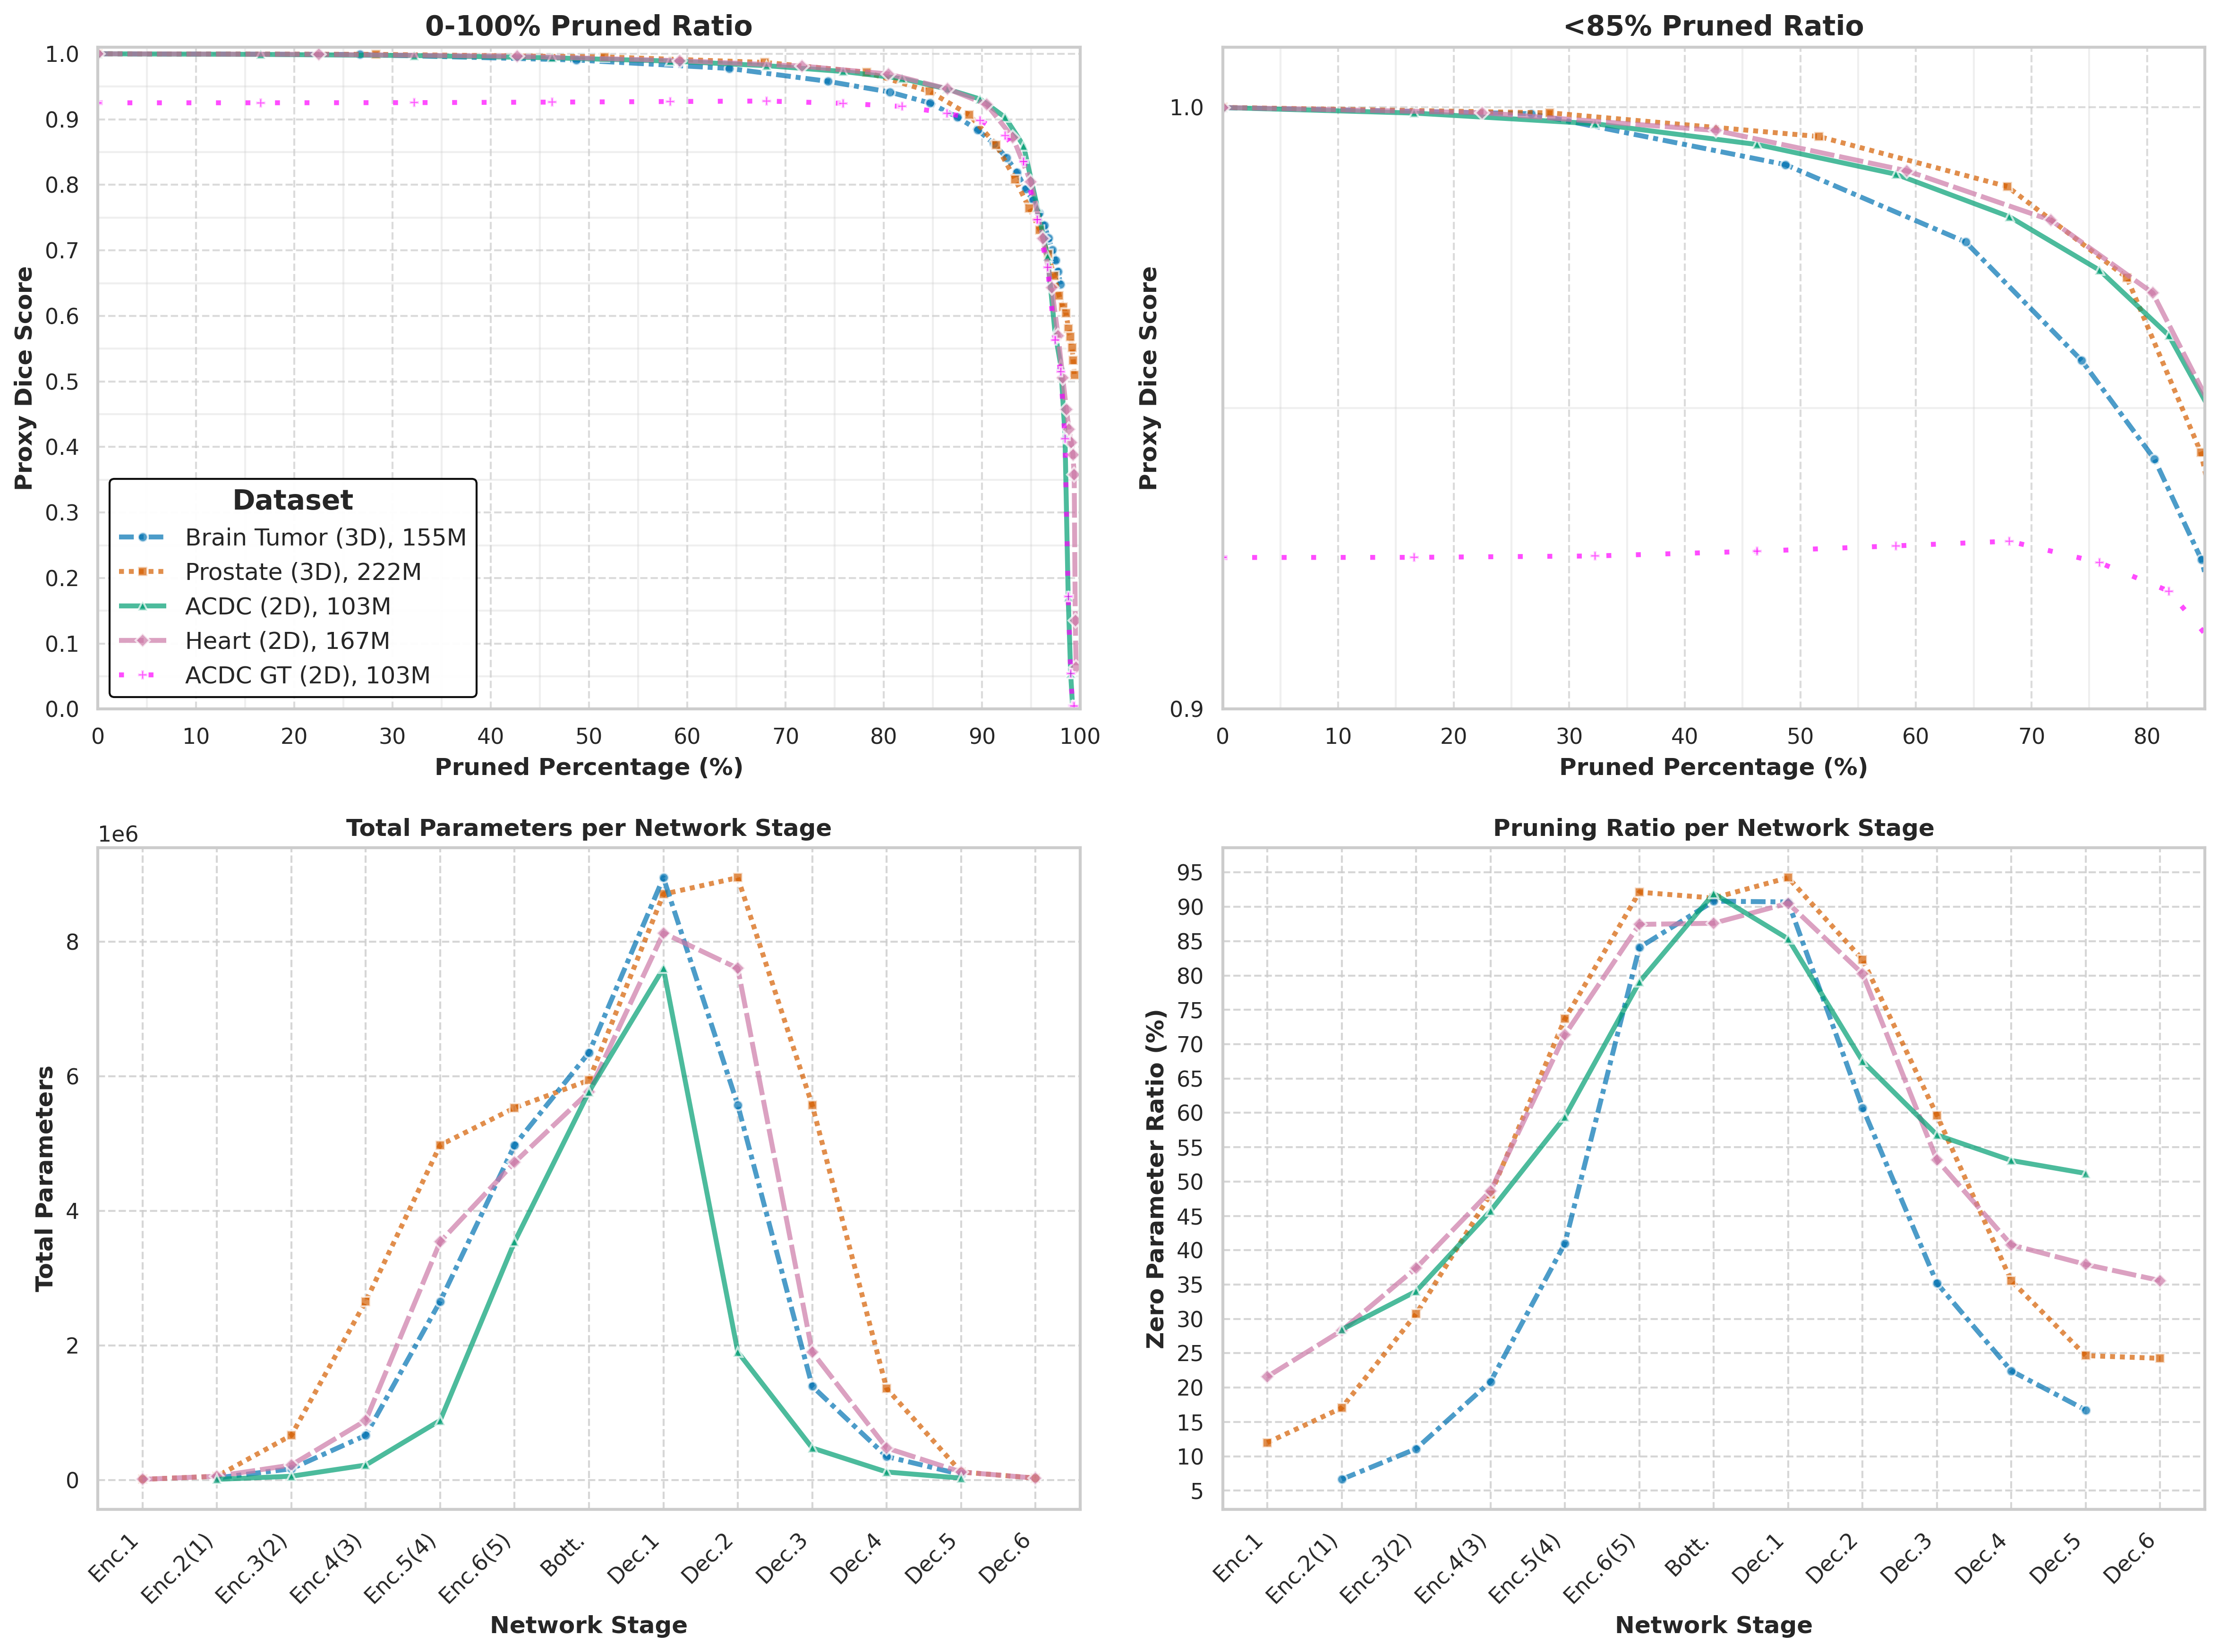

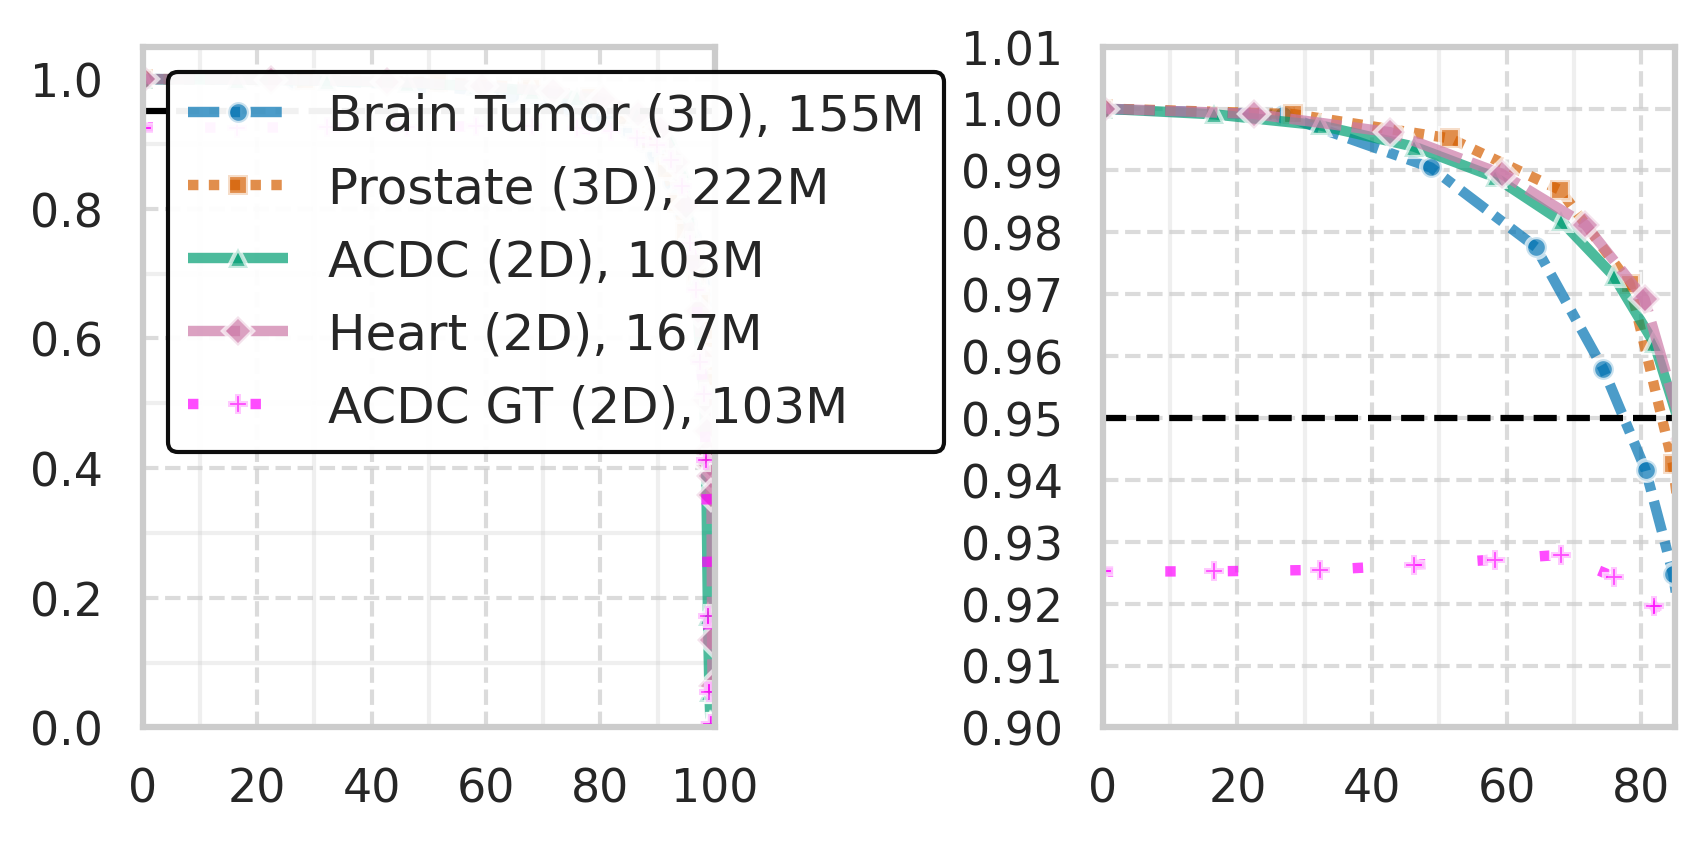

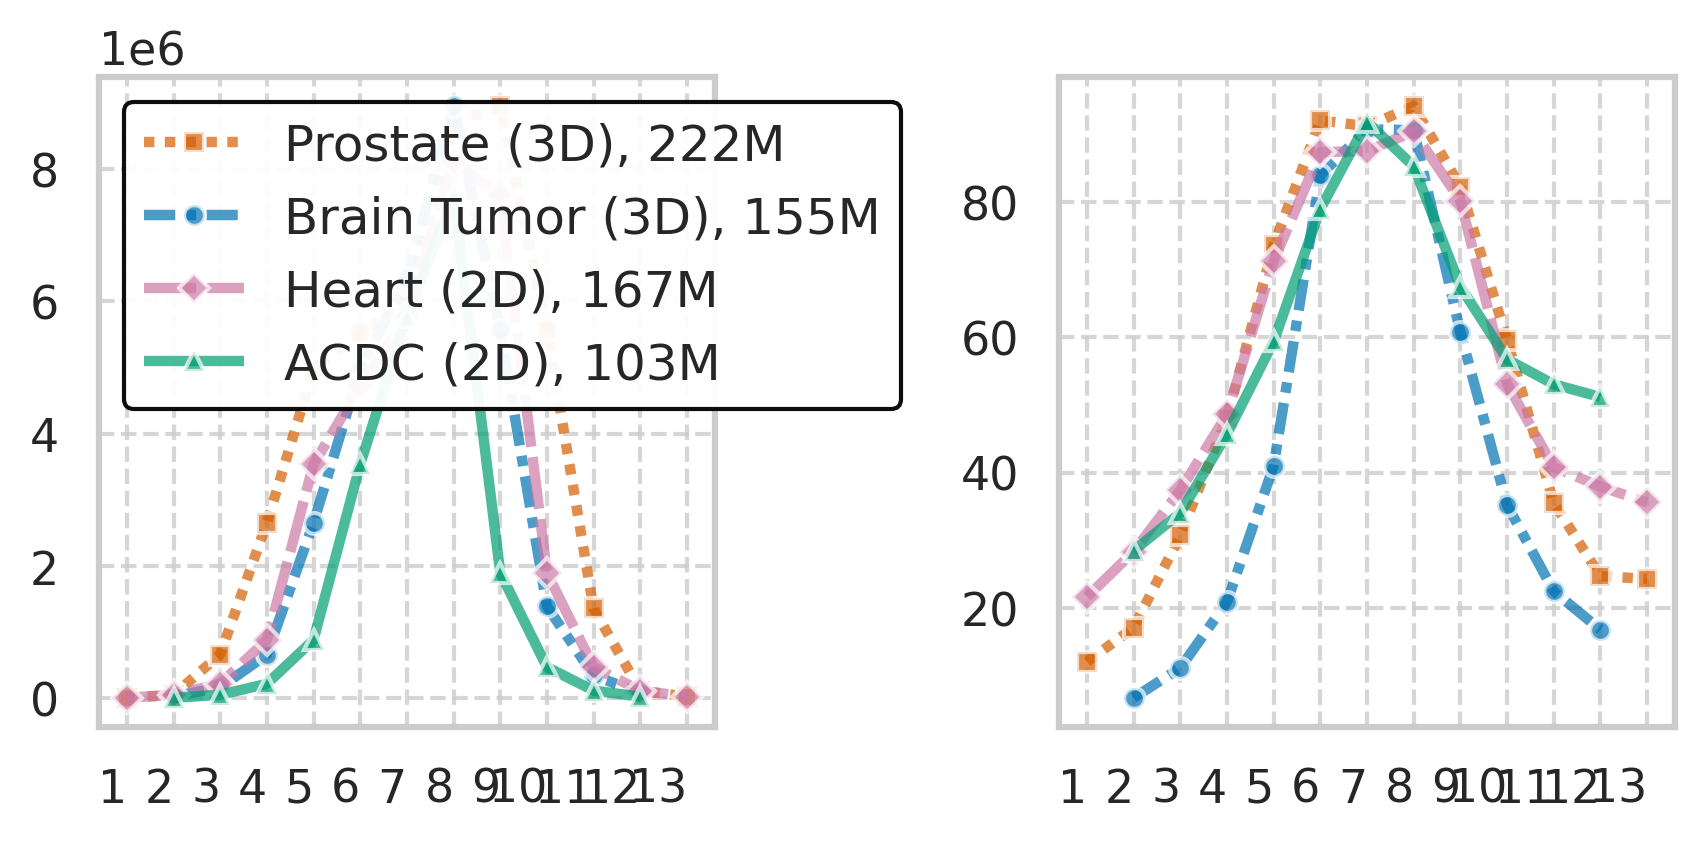

In [5]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.patches as mpatches

# Set SVG-specific rcParams and centimeter conversion
rcParams['svg.fonttype'] = 'none'
cm = 0.393701

sns.set_theme(style="whitegrid")
rcParams['font.size'] = 18
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5

# =============================================================================
# 1. Load Data and Prepare Datasets & Analysis
# =============================================================================

# --- Updated: Add extra entry "acdc_gt" ---
data_file_paths = {
    "brain": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset001_BrainTumour/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/pruning_analysis_results.csv",
    "prostate": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset005_Prostate/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/pruning_analysis_results.csv",
    "acdc": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset027_ACDC/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv",
    "heart": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset002_Heart/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv",
    "acdc_gt": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset027_ACDC/GT__FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/pruning_analysis_results.csv"
}

# File paths for bottom row text files remain unchanged (acdc_gt is omitted here)
paths = {
    "prostate": "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset005_Prostate/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/max_val_4e-3__min_val_-4e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "brain":    "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset001_BrainTumour/FlexibleTrainerV1__nnUNetPlans__3d_fullres/RangePruning/max_val_4e-3__min_val_-4e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "heart":    "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset002_Heart/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/max_val_5e-3__min_val_-5e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt",
    "acdc":     "/media/tonguyunyang/tony_data/data/pruning_nnunet_experiment_storage/nnUNet_pruning/Dataset027_ACDC/FlexibleTrainerV1__nnUNetPlans__2d/RangePruning/max_val_7e-3__min_val_-7e-3__prune_bias_True__prune_layers_conv__prune_weights_True/ensemble_0_1_2_3_4/final_model/zero_parameter_analysis_0.txt"
}

# --- Updated: Include "acdc_gt" in labeling and styling dictionaries for top plots ---
task_labels = {
    "brain": "Brain Tumor (3D), 155M",
    "prostate": "Prostate (3D), 222M",
    "acdc": "ACDC (2D), 103M",
    "heart": "Heart (2D), 167M",
    "acdc_gt": "ACDC GT (2D), 103M"  # new label for GT data
}

dataset_colors = {
    "brain": "#0072B2",
    "prostate": "#D55E00",
    "acdc": "#009E73",
    "heart": "#CC79A7",
    "acdc_gt": "#FF00FF"  # new color for acdc_gt
}

dataset_line_styles = {
    "brain": (0, (3, 1, 1, 1)),
    "prostate": (0, (1, 1)),
    "acdc": (0, (1, 0)),
    "heart": (0, (5, 1)),
    "acdc_gt": (0, (1, 5))  # new linestyle for acdc_gt
}

dataset_markers = {
    "brain": "o",
    "prostate": "s",
    "acdc": "^",
    "heart": "D",
    "acdc_gt": "P"  # new marker for acdc_gt
}

datasets = {}
for dataset, file_path in data_file_paths.items():
    df_data = pd.read_csv(file_path)
    # Ensure that scientific notation strings (e.g., "0e+") are properly interpreted
    df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
    df_data['max_val'] = df_data['max_val'].replace("0.0e+", "0e+0")
    df_data['max_val'] = pd.to_numeric(df_data['max_val'], errors='coerce')
    df_data['pruning_pct'] = df_data['total_percentage']
    df_data.rename(columns={"performance_Dice": "dice_score"}, inplace=True)
    datasets[dataset] = df_data

# --- Updated plotting function for Dice vs. Pruning Percentage ---
def plot_dice_vs_pruning_pct(ax, xlim, ylim, x_major_locator, x_minor_locator):
    for dataset, df_data in datasets.items():
        df_data['max_val'] = df_data['max_val'].replace("0e+", "0e+0")
        df_data['max_val'] = df_data['max_val'].replace("0.0e+", "0e+0")
        filtered_df = df_data[(df_data['max_val'] >= 0) & (df_data['max_val'] <= 2e-2)]
        filtered_df = filtered_df.sort_values(by='pruning_pct', ascending=True)
        ax.plot(filtered_df['pruning_pct'], filtered_df['dice_score'],
                label=task_labels[dataset],
                color=dataset_colors[dataset],
                marker=dataset_markers[dataset],
                linestyle=dataset_line_styles[dataset],
                markersize=5, linewidth=2.5,
                markeredgecolor='white', markeredgewidth=1,
                alpha=0.7)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.set_major_locator(x_major_locator)
    ax.xaxis.set_minor_locator(x_minor_locator)
    # Set default y-tick locators (these may be overridden later)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which='minor', alpha=0.3)

# (Stage-analysis code remains the same.)
def analyze_zero_parameter_file(file_path):
    encoder_stages = {}
    decoder_stages = {}
    decoder_to_merge = {"zeros": 0, "total": 0}
    prefix_pattern = re.compile(r'^(encoder|decoder)\.(?P<subtype>stages|transpconvs|seg_layers)\.(?P<stage>\d+)')
    num_pattern = re.compile(r':\s*(\d+)/(\d+)\s+zeros')
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("SUMMARY:"):
                continue
            prefix_match = prefix_pattern.match(line)
            if not prefix_match:
                continue
            arch = prefix_match.group(1)
            subtype = prefix_match.group("subtype")
            stage_idx = int(prefix_match.group("stage"))
            if arch == "encoder":
                if subtype != "stages":
                    continue
                if stage_idx not in encoder_stages:
                    encoder_stages[stage_idx] = {"zeros": 0, "total": 0}
                num_match = num_pattern.search(line)
                if not num_match:
                    continue
                zeros = int(num_match.group(1))
                total = int(num_match.group(2))
                encoder_stages[stage_idx]["zeros"] += zeros
                encoder_stages[stage_idx]["total"] += total
            else:  # decoder
                num_match = num_pattern.search(line)
                if not num_match:
                    continue
                zeros = int(num_match.group(1))
                total = int(num_match.group(2))
                if subtype == "stages":
                    new_stage = stage_idx
                    if new_stage not in decoder_stages:
                        decoder_stages[new_stage] = {"zeros": 0, "total": 0}
                    decoder_stages[new_stage]["zeros"] += zeros
                    decoder_stages[new_stage]["total"] += total
                elif subtype in ("transpconvs", "seg_layers"):
                    new_stage = stage_idx - 1
                    if new_stage < 0:
                        decoder_to_merge["zeros"] += zeros
                        decoder_to_merge["total"] += total
                    else:
                        if new_stage not in decoder_stages:
                            decoder_stages[new_stage] = {"zeros": 0, "total": 0}
                        decoder_stages[new_stage]["zeros"] += zeros
                        decoder_stages[new_stage]["total"] += total
    if decoder_to_merge["total"] > 0:
        if encoder_stages:
            bottleneck_index = max(encoder_stages.keys())
            encoder_stages[bottleneck_index]["zeros"] += decoder_to_merge["zeros"]
            encoder_stages[bottleneck_index]["total"] += decoder_to_merge["total"]
        else:
            encoder_stages[0] = decoder_to_merge
    return encoder_stages, decoder_stages

dataset_info = {}
max_encoder_depth = 0
max_decoder_depth = 0
for dataset, file_path in paths.items():
    try:
        encoder_stages, decoder_stages = analyze_zero_parameter_file(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        continue
    e_i = max(encoder_stages.keys()) + 1 if encoder_stages else 0
    d_i = max(decoder_stages.keys()) + 1 if decoder_stages else 0
    max_encoder_depth = max(max_encoder_depth, e_i)
    max_decoder_depth = max(max_decoder_depth, d_i)
    dataset_info[dataset] = {
        "encoder_dict": encoder_stages,
        "decoder_dict": decoder_stages,
        "num_encoder_stages": e_i,
        "num_decoder_stages": d_i
    }

# Align stage data across datasets.
E = max_encoder_depth
D = max_decoder_depth
x_positions = list(range(1, E + D + 1))
total_params_data = {}
zero_ratio_data = {}
for dataset, info in dataset_info.items():
    e_i = info["num_encoder_stages"]
    d_i = info["num_decoder_stages"]
    enc_dict = info["encoder_dict"]
    dec_dict = info["decoder_dict"]
    y_total = [None] * (E + D)
    y_ratio = [None] * (E + D)
    for k in range(e_i):
        x_enc = E - e_i + (k + 1)
        if 1 <= x_enc <= (E + D):
            zeros_k = enc_dict[k]["zeros"]
            total_k = enc_dict[k]["total"]
            y_total[x_enc - 1] = total_k
            y_ratio[x_enc - 1] = (zeros_k / total_k * 100) if total_k > 0 else None
    for j in range(d_i):
        x_dec = E + (j + 1)
        if 1 <= x_dec <= (E + D):
            zeros_j = dec_dict[j]["zeros"]
            total_j = dec_dict[j]["total"]
            y_total[x_dec - 1] = total_j
            y_ratio[x_dec - 1] = (zeros_j / total_j * 100) if total_j > 0 else None
    total_params_data[dataset] = y_total
    zero_ratio_data[dataset] = y_ratio

# Create custom x-axis tick labels.
x_labels = []
for x in x_positions:
    if x < E:
        if x == 1:
            x_labels.append("Enc.1")
        else:
            x_labels.append(f"Enc.{x}({x-1})")
    elif x == E:
        x_labels.append("Bott.")
    else:
        x_labels.append(f"Dec.{x - E}")

# =============================================================================
# 2. (Optional) Create the Combined Figure for PDF/PNG (Unchanged apart from marker changes)
# =============================================================================

fig_combined = plt.figure(figsize=(16, 12), dpi=300)
grid_spec = fig_combined.add_gridspec(2, 2)

ax_dice_pct_full = fig_combined.add_subplot(grid_spec[0, 0])
ax_dice_pct_low = fig_combined.add_subplot(grid_spec[0, 1])
# Use the original locator settings for the combined figure
plot_dice_vs_pruning_pct(ax_dice_pct_full, (0, 100), (0, 1.01), MultipleLocator(10), MultipleLocator(5))
ax_dice_pct_full.set_xlabel('Pruned Percentage (%)', fontweight='bold')
ax_dice_pct_full.set_ylabel('Proxy Dice Score', fontweight='bold')
ax_dice_pct_full.set_title('0-100% Pruned Ratio', fontsize=14, fontweight='bold')
# Legend is added in the combined figure
legend_full = ax_dice_pct_full.legend(title='Dataset', loc='lower left',
                                      frameon=True, framealpha=0.95, edgecolor='black',
                                      fontsize=12, title_fontsize=14)
legend_full.get_title().set_fontweight('bold')

plot_dice_vs_pruning_pct(ax_dice_pct_low, (0, 85), (0.9, 1.01), MultipleLocator(10), MultipleLocator(5))
ax_dice_pct_low.set_xlabel('Pruned Percentage (%)', fontweight='bold')
ax_dice_pct_low.set_ylabel('Proxy Dice Score', fontweight='bold')
ax_dice_pct_low.set_title('<85% Pruned Ratio', fontsize=14, fontweight='bold')

ax_total = fig_combined.add_subplot(grid_spec[1, 0])
ax_ratio = fig_combined.add_subplot(grid_spec[1, 1])
for dataset in dataset_info.keys():
    y_total = total_params_data[dataset]
    y_ratio = zero_ratio_data[dataset]
    ax_total.plot(x_positions, y_total, label=task_labels.get(dataset, dataset),
                  color=dataset_colors[dataset], marker=dataset_markers[dataset],
                  linestyle=dataset_line_styles[dataset], markersize=5, linewidth=2.5,
                  markeredgecolor='white', markeredgewidth=1, alpha=0.7)
    ax_ratio.plot(x_positions, y_ratio, label=task_labels.get(dataset, dataset),
                  color=dataset_colors[dataset], marker=dataset_markers[dataset],
                  linestyle=dataset_line_styles[dataset], markersize=5, linewidth=2.5,
                  markeredgecolor='white', markeredgewidth=1, alpha=0.7)

ax_total.set_xlabel("Network Stage", fontweight='bold')
ax_total.set_ylabel("Total Parameters", fontweight='bold')
ax_total.set_title("Total Parameters per Network Stage", fontweight='bold')
ax_total.grid(True, linestyle='--', alpha=0.8)
ax_total.xaxis.set_major_locator(MultipleLocator(1))
ax_total.set_xticks(x_positions)
ax_total.set_xticklabels(x_labels, rotation=45, ha='right')

ax_ratio.set_xlabel("Network Stage", fontweight='bold')
ax_ratio.set_ylabel("Zero Parameter Ratio (%)", fontweight='bold')
ax_ratio.set_title("Pruning Ratio per Network Stage", fontweight='bold')
ax_ratio.grid(True, linestyle='--', alpha=0.8)
ax_ratio.xaxis.set_major_locator(MultipleLocator(1))
ax_ratio.set_xticks(x_positions)
ax_ratio.set_xticklabels(x_labels, rotation=45, ha='right')
ax_ratio.yaxis.set_major_locator(MultipleLocator(5))
ax_ratio.yaxis.set_minor_locator(MultipleLocator(1))

plt.tight_layout()
plt.savefig('combined_pruning_performance.pdf', bbox_inches='tight')
plt.savefig('combined_pruning_performance.png', bbox_inches='tight', dpi=300)
plt.savefig('combined_pruning_performance.svg', bbox_inches='tight')
plt.show()

# =============================================================================
# 3. Create Separate Figures for SVG without Any Titles or Axis Labels
# =============================================================================

# --- Top Row Figure (Dice vs. Pruned Percentage) without labels or titles ---
fig_top = plt.figure(figsize=(15.3*cm, 8*cm), dpi=300)
ax_dice_pct_full_svg = fig_top.add_subplot(1, 2, 1)
ax_dice_pct_low_svg  = fig_top.add_subplot(1, 2, 2)

# Plot with fewer x ticks
plot_dice_vs_pruning_pct(ax_dice_pct_full_svg, (0, 100), (0, 1.05), MultipleLocator(20), MultipleLocator(10))
plot_dice_vs_pruning_pct(ax_dice_pct_low_svg, (0, 85), (0.9, 1.01), MultipleLocator(20), MultipleLocator(10))

# Remove subplot titles (if any)
ax_dice_pct_full_svg.set_title("")
ax_dice_pct_low_svg.set_title("")

# Remove x and y axis labels
ax_dice_pct_full_svg.set_xlabel("")
ax_dice_pct_full_svg.set_ylabel("")
ax_dice_pct_low_svg.set_xlabel("")
ax_dice_pct_low_svg.set_ylabel("")

# Adjust y-tick locators:
# Top left: fewer y ticks (larger intervals)
ax_dice_pct_full_svg.yaxis.set_major_locator(MultipleLocator(0.2))
ax_dice_pct_full_svg.yaxis.set_minor_locator(MultipleLocator(0.1))
# Top right: many y ticks (smaller intervals)
ax_dice_pct_low_svg.yaxis.set_major_locator(MultipleLocator(0.01))
ax_dice_pct_low_svg.yaxis.set_minor_locator(MultipleLocator(0.01))

ax_dice_pct_full_svg.axhline(y=0.95, color='black', linestyle='--', linewidth=1.5)
ax_dice_pct_low_svg.axhline(y=0.95, color='black', linestyle='--', linewidth=1.5)

# Add a legend on the top left subplot WITHOUT a title.
legend_top = ax_dice_pct_full_svg.legend(loc='upper left',
                                         frameon=True,
                                         framealpha=0.95,
                                         edgecolor='black',
                                         fontsize=12)
# (Legend title is not specified, so none is shown.)

fig_top.tight_layout()
fig_top.savefig('combined_pruning_performance_top.svg', bbox_inches='tight')

# --- Bottom Row Figure (Stage Analysis) without labels or titles ---
fig_bottom = plt.figure(figsize=(15.3*cm, 8*cm), dpi=300)
ax_total_svg = fig_bottom.add_subplot(1, 2, 1)
ax_ratio_svg = fig_bottom.add_subplot(1, 2, 2)

# Add a horizontal reference line at y=0.95


# Plot stage analysis data with the updated marker settings.
for dataset in dataset_info.keys():
    y_total = total_params_data[dataset]
    y_ratio = zero_ratio_data[dataset]
    ax_total_svg.plot(x_positions, y_total,
                      label=task_labels.get(dataset, dataset),
                      color=dataset_colors[dataset],
                      marker=dataset_markers[dataset],
                      linestyle=dataset_line_styles[dataset],
                      markersize=5, linewidth=2.5,
                      markeredgecolor='white', markeredgewidth=1,
                      alpha=0.7)
    ax_ratio_svg.plot(x_positions, y_ratio,
                      label=task_labels.get(dataset, dataset),
                      color=dataset_colors[dataset],
                      marker=dataset_markers[dataset],
                      linestyle=dataset_line_styles[dataset],
                      markersize=5, linewidth=2.5,
                      markeredgecolor='white', markeredgewidth=1,
                      alpha=0.7)

# Remove titles for both subplots
ax_total_svg.set_title("")
ax_ratio_svg.set_title("")

# Remove axis labels for both subplots
ax_total_svg.set_xlabel("")
ax_total_svg.set_ylabel("")
ax_ratio_svg.set_xlabel("")
ax_ratio_svg.set_ylabel("")

# Set grid and x-axis tick labels (tick labels remain intact if desired)
ax_total_svg.grid(True, linestyle='--', alpha=0.8)
ax_total_svg.xaxis.set_major_locator(MultipleLocator(1))
ax_total_svg.set_xticks(x_positions)
ax_total_svg.set_xticklabels(x_labels, ha='right')

ax_ratio_svg.grid(True, linestyle='--', alpha=0.8)
ax_ratio_svg.xaxis.set_major_locator(MultipleLocator(1))
ax_ratio_svg.set_xticks(x_positions)
ax_ratio_svg.set_xticklabels(x_labels, ha='right')
ax_ratio_svg.yaxis.set_major_locator(MultipleLocator(50))

# Update the x-axis tick labels using the simple labels
# Create simple x-axis tick labels (just the stage number as a string)
simple_x_labels = [str(x) for x in x_positions]

ax_total_svg.grid(True, linestyle='--', alpha=0.8)
ax_total_svg.xaxis.set_major_locator(MultipleLocator(1))
ax_total_svg.set_xticks(x_positions)
ax_total_svg.set_xticklabels(simple_x_labels, ha='right')

ax_ratio_svg.grid(True, linestyle='--', alpha=0.8)
ax_ratio_svg.xaxis.set_major_locator(MultipleLocator(1))
ax_ratio_svg.set_xticks(x_positions)
ax_ratio_svg.set_xticklabels(simple_x_labels, ha='right')
ax_ratio_svg.yaxis.set_major_locator(MultipleLocator(20))
# (Minor ticks can be removed if desired.)
# Add a legend on the bottom left subplot without a legend title.
legend_bottom = ax_total_svg.legend(loc='upper left',
                                    frameon=True,
                                    framealpha=0.95,
                                    edgecolor='black',
                                    fontsize=12)
fig_bottom.tight_layout()
fig_bottom.savefig('combined_pruning_performance_bottom.svg', bbox_inches='tight')

plt.show()
